In [1]:
import pickle
import random
from os.path import join

from copy import deepcopy, copy
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from tqdm import tqdm
from numpy import interp
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve, matthews_corrcoef
from indra.statements import pretty_print_stmts as pps
from indra.tools import assemble_corpus as ac
from sklearn.neighbors import KNeighborsClassifier
from indra.belief import BeliefEngine, get_ev_for_stmts_from_supports
from indra.belief.skl import CountsScorer
from bioexp.util import format_axis, fontsize
from bioexp.curation.belief_models import OrigBeliefStmt, OrigBelief
from bioexp.curation.get_ev_distro import get_reader_ev_pmid_distro
from bioexp.curation.classifiers import BinaryRandomForest, LogLogisticRegression #, BeliefModel

# TEMP
from bioexp.curation.model_fit import ModelFit, ens_sample
from multiprocessing import Pool



from bioexp.curation.process_curations import get_full_curations, get_raw_curations, reader_input
%matplotlib notebook

In [2]:
# Load pickle of assembled statements.
all_stmts = ac.load_statements('../data/bioexp_asmb_preassembled.pkl')

INFO: [2021-07-26 13:33:51] indra.tools.assemble_corpus - Loading ../data/bioexp_asmb_preassembled.pkl...
INFO: [2021-07-26 13:35:12] indra.tools.assemble_corpus - Loaded 895580 statements


Make a dictionary so we can retrieve statements by their hash, and define some other useful variables:

In [3]:
stmts_by_hash = {s.get_hash(): s for s in all_stmts}

reader_list = ['reach', 'sparser', 'medscan', 'rlimsp', 'trips']

opath = '../output/'
prefix = 'fig4_ipynb'

def fig_path(name, fmt):
    return join(opath, f'{prefix}_{name}.{fmt}')

In [4]:
# Filter out statements with None agents and those with only DB support.
reader_stmts = []
for stmt in tqdm(all_stmts):
    if None in stmt.agent_list():
        continue
    if not set([ev.source_api for ev in stmt.evidence]).intersection(set(reader_list)):
        pass
    else:
        reader_stmts.append(stmt)

100%|██████████| 895580/895580 [00:05<00:00, 149389.27it/s]


Load the curated data:

In [5]:
#curation_data_file = join(opath, 'curation_dataset_with_bg_psp.pkl')
#curation_data_file = join(opath, 'curation_dataset.pkl')
curation_data_file = join(opath, 'curation_dataset_inc.pkl')

def load_curation_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
        df = pd.DataFrame.from_records(dataset)
        df = df.fillna(0)
    # Every column except agent names and stmt type should be int
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('agA_name', 'agA_ns', 'agA_id', 'stmt_type',
                                 'agB_name', 'agB_ns', 'agB_id')}
    df = df.astype(dtype_dict)
    return df

cur_df = load_curation_data(curation_data_file)

How many records in the dataset?

In [6]:
cur_df.shape

(1330, 30)

Get a list of all the curated statements:

In [7]:
# Get dataset of curated statements along with correctness values
def stmts_for_df(df, stmts_by_hash):
    stmt_list = []
    for row in df.itertuples():
        stmt_hash = row.stmt_hash
        stmt_list.append(stmts_by_hash[stmt_hash])
    return stmt_list

cur_stmts = stmts_for_df(cur_df, stmts_by_hash)

## Statement Weights

Load the weights for reader combinations:

In [8]:
# Load the weights
wt_df = pd.read_pickle('curation_inc_wts.pkl')
wt_dict = wt_df.to_dict()

In [9]:
wt_df

Readers
(R, _, _, _, _)    3.520201
(_, _, M, _, _)    2.333755
(_, S, _, _, _)    4.874718
(R, _, M, _, _)    0.705768
(R, S, _, _, _)    0.691016
(R, S, M, _, _)    0.280441
(_, S, M, _, _)    0.667432
(R, S, M, _, T)    0.040638
(_, _, _, _, T)    0.094415
(_, _, _, P, _)    0.078024
(R, S, _, _, T)    0.089018
(R, S, _, P, _)    0.054615
(R, _, M, _, T)    0.082655
(R, _, _, _, T)    0.122287
(R, S, M, P, _)    0.036891
(_, _, M, _, T)    0.084792
(_, S, _, P, _)    0.130921
(_, S, _, _, T)    0.076457
(_, S, M, _, T)    0.067284
(R, _, _, P, _)    0.056483
(R, S, M, P, T)    0.016931
(_, _, M, P, _)    0.071686
(R, S, _, P, T)    0.025198
(_, S, M, P, _)    0.046623
(_, S, _, P, T)    0.051312
(R, _, M, P, _)    0.199965
(R, _, _, P, T)    0.067913
(_, S, M, P, T)    0.012073
(_, _, _, P, T)    0.049048
(R, _, M, P, T)    0.019808
(_, _, M, P, T)         inf
dtype: float64

Get weights for each statement:

In [10]:
def reader_set_to_tuple(rset, r_list):
    """Converts a frozen set of sources e.g. {reach, sparser} into a tuple 
       of the form (R, S, _, _, _) for use in displaying results."""
    rtup = []
    reader_abbrevs = {'reach': 'R', 'sparser': 'S', 'medscan': 'M',
                  'rlimsp': 'P', 'trips': 'T'}
    # Follow the order of readers in reader_list
    for r in r_list:
        if r in rset:
            rtup.append(reader_abbrevs[r])
        else:
            rtup.append('_')
    return tuple(rtup)

wt_list = []
for stmt in tqdm(cur_stmts):
    sources = frozenset([ev.source_api for ev in stmt.evidence
                         if ev.source_api in reader_list])
    
    rtup = reader_set_to_tuple(sources, reader_list)
    wt_list.append(wt_dict[rtup])

100%|██████████| 1330/1330 [00:00<00:00, 78968.65it/s]


Monkey-patch a weight field into the statement objects:

In [11]:
for stmt, wt in zip(cur_stmts, wt_list):
    stmt.weight = wt

Add the reader combination weight to the curation dataframe:

In [12]:
cur_df['stmt_weight'] = wt_list

For statements supported by a particular reader, get the total weight associated with a particular evidence count for that reader:

In [13]:
wt_reader = 'reach'
reader_df = cur_df[cur_df[wt_reader] > 0]
total_reader_wt = reader_df['stmt_weight'].sum()
total_reader_wt

INFO: [2021-07-26 13:35:49] numexpr.utils - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: [2021-07-26 13:35:49] numexpr.utils - NumExpr defaulting to 8 threads.


827.2681419870586

In [14]:
derived_reader_count_wts = reader_df.groupby(wt_reader).sum()['stmt_weight'] / total_reader_wt

The derived reader count weights gives the relative weight that a particular reader evidence count is given according to the current weighting scheme.

In [15]:
derived_reader_count_wts

reach
1      0.314161
2      0.162213
3      0.125739
4      0.063684
5      0.071205
         ...   
243    0.000049
248    0.000049
276    0.000108
289    0.000049
306    0.000049
Name: stmt_weight, Length: 88, dtype: float64

Generate a dataframe for the *actual* reader count frequencies from the whole corpus. First step is to turn the statements into a dataframe of source counts.

In [16]:
def get_reader_counts_from_stmts(stmts):
    """Get a dataframe with source counts for each statement."""
    data = []
    for stmt in tqdm(stmts):
        ev_dict = dict(Counter([ev.source_api for ev in stmt.evidence]))
        ev_dict['stmt_hash'] = stmt.get_hash()
        ev_dict['stmt_type'] = stmt.__class__.__name__
        ev_dict['agA_name'] = stmt.agent_list()[0].name
        if len(stmt.agent_list()) == 2:
            ev_dict['agB_name'] = stmt.agent_list()[1].name
        else:
            continue
        data.append(ev_dict)
    df = pd.DataFrame(data).fillna(0)
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('stmt_num', 'stmt_hash', 'agA_name', 'stmt_type', 'agB_name')}
    return df.astype(dtype_dict)

corpus_freqs = get_reader_counts_from_stmts(reader_stmts)

100%|██████████| 705022/705022 [00:09<00:00, 73928.54it/s] 


In [17]:
corpus_freqs

,reach,stmt_hash,stmt_type,agA_name,agB_name,sparser,medscan,trips,signor,bel,hprd,biopax,isi,trrust,rlimsp
0,1,24562337727389247,Acetylation,ADRB,Histone,0,0,0,0,0,0,0,0,0,0
1,1,32657840369481553,Acetylation,AKT,BECN1,0,0,0,0,0,0,0,0,0,0
2,1,-20714576200854538,Acetylation,AKT,EP300,0,0,0,0,0,0,0,0,0,0
3,1,32067530839791152,Acetylation,AKT,AKT,0,0,0,0,0,0,0,0,0,0
4,1,28647677350220903,Acetylation,AKT,FOXO,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659768,1,-4407728529344669,Ubiquitination,TRIM13,CASP8,0,0,0,0,0,0,0,0,0,0
659769,1,1621422231354259,Ubiquitination,TRIM13,IKBKG,0,0,0,0,0,0,0,0,0,0
659770,3,-7594887848327933,Ubiquitination,TRIM13,CASP8,0,0,0,0,0,0,0,0,0,0
659771,1,-24859706091069607,Ubiquitination,TRIM13,IKBKG,0,0,0,0,0,0,0,0,0,0


In [18]:
len(reader_stmts)

705022

Now, for the reader whose relative frequencies we are focusing on, get the total number of statements associated with that reader:

In [19]:
reader_total = len(corpus_freqs[corpus_freqs[wt_reader] > 0])
reader_total

432598

Next get the total number of statements for each evidence count for the reader:

In [20]:
corpus_freqs[corpus_freqs[wt_reader] > 0].groupby(wt_reader).count()

,stmt_hash,stmt_type,agA_name,agB_name,sparser,medscan,trips,signor,bel,hprd,biopax,isi,trrust,rlimsp
reach,,,,,,,,,,,,,,
1,292037,292037,292037,292037,292037,292037,292037,292037,292037,292037,292037,292037,292037,292037
2,66570,66570,66570,66570,66570,66570,66570,66570,66570,66570,66570,66570,66570,66570
3,26479,26479,26479,26479,26479,26479,26479,26479,26479,26479,26479,26479,26479,26479
4,14353,14353,14353,14353,14353,14353,14353,14353,14353,14353,14353,14353,14353,14353
5,8528,8528,8528,8528,8528,8528,8528,8528,8528,8528,8528,8528,8528,8528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,1,1,1,1,1,1,1,1,1,1,1,1,1,1
719,1,1,1,1,1,1,1,1,1,1,1,1,1,1
738,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Still not entirely sure what these next two blocks are supposed to do. I assumed the idea was to compare the derived weights with the actual weights.

In [21]:
reader_total = 0
reader1 = 0
for stmt in tqdm(reader_stmts):
    source_api_ctr = Counter([ev.source_api for ev in stmt.evidence])
    if 'reach' in source_api_ctr:
        reader_total += 1
    if source_api_ctr['reach'] == 1:
        reader1 += 1

100%|██████████| 705022/705022 [00:04<00:00, 165499.79it/s]


In [22]:
reader_count_total_wts = {}
reader_total_wt = defaultdict(lambda: 0)
for stmt in cur_stmts:
    # Get the readers for the stmt
    source_api_ctr = Counter([ev.source_api for ev in stmt.evidence])
    for reader in reader_list:
        if reader in source_api_ctr:
            if reader not in reader_count_total_wts:
                reader_count_total_wts[reader] = defaultdict(lambda: 0)
            reader_count_total_wts[reader][source_api_ctr.get(reader)] += stmt.weight
        reader_total_wt[reader] += stmt.weight
reader_total_wt = dict(reader_total_wt)
reader_count_total_wts = dict(reader_count_total_wts)

In [23]:
reader_total_wt

{'reach': 1329.973589476637,
 'sparser': 1329.973589476637,
 'medscan': 1329.973589476637,
 'rlimsp': 1329.973589476637,
 'trips': 1329.973589476637}

## Code for fitting models

List all the source APIs for curated statements:

In [25]:
all_sources = list(set([ev.source_api for stmt in cur_stmts for ev in stmt.evidence]))
all_sources

['trips',
 'rlimsp',
 'medscan',
 'isi',
 'biopax',
 'hprd',
 'bel',
 'signor',
 'reach',
 'trrust',
 'sparser']

Define classes for storing the results of training and testing models. `TrainTestResult` Records the predictions, probabilities, RO curve, PR curve, etc. for a single fold of the data. `ModelResult` aggregates the `TrainTestResult` objects for all of the folds.

In [26]:
class TrainTestResult:
    def __init__(self, y_preds, y_probs, y_test, base_fpr, sample_wts):
        self.y_preds = y_preds
        self.y_probs = y_probs      
        self.y_test = y_test
        self.sample_wts = sample_wts

        # Get and store true/false positive rates and thresholds for ROC curve
        self.fpr, self.tpr, self.thresholds = roc_curve(y_test, y_probs[:, 1],
                                                        sample_weight=self.sample_wts)
        # Calculate ROC AUC
        self.roc_auc = auc(self.fpr, self.tpr)
        # Get TPR interpolated to base_fpr
        self.tpr_interp = interp(base_fpr, self.fpr, self.tpr)
        self.tpr_interp[0] = 0.0
        # Precision/recall/thresholds for each model
        self.precision, self.recall, self.thresholds = \
                    precision_recall_curve(y_test, y_probs[:, 1], sample_weight=self.sample_wts)
        self.pr_auc = auc(self.recall, self.precision)
        #pr_auc_arr[fold_ix] = pr_auc
        self.prec_interp = interp(base_fpr, self.thresholds, self.precision[:-1])
        #prec_arr[fold_ix, :] = interp(base_fpr, thresholds, precision[:-1])
        self.rec_interp = interp(base_fpr, self.thresholds, self.recall[:-1])
        self.mcc = matthews_corrcoef(y_test, y_preds, sample_weight=self.sample_wts)

class ModelResults:
    def __init__(self, clf_name, feat_set_name, feat_kwargs, base_fpr):
        # True positives
        self.base_fpr = base_fpr
        self.clf_name = clf_name
        self.feat_set_name = feat_set_name
        self.feat_kwargs = feat_kwargs
        self.tt_results = []
        
    def add_result(self, tt_result):
        self.tt_results.append(tt_result)

    def get_summary(self):
        clf_results = [{'y_preds': tt.y_preds,
                        'y_probs': tt.y_probs,
                        'y_test': tt.y_test} for tt in self.tt_results]
        # Combine get matrices with all TPR, Precision and Recall results
        dim = (len(self.tt_results), len(self.base_fpr))
        tpr_arr = np.zeros(dim)
        prec_arr = np.zeros(dim)
        rec_arr = np.zeros(dim)
        for ix, ttr in enumerate(self.tt_results):
            tpr_arr[ix, :] = ttr.tpr_interp
            prec_arr[ix, :] = ttr.prec_interp
            rec_arr[ix, :] = ttr.rec_interp
        return {
         'clf': clf_results,
         'mcc': np.array([ttr.mcc for ttr in self.tt_results]),
         'roc': tpr_arr.mean(axis=0),
         'roc_auc': np.array([ttr.roc_auc for ttr in self.tt_results]),
         'prec': prec_arr.mean(axis=0),
         'rec': rec_arr.mean(axis=0),
         'pr_auc': np.array([ttr.pr_auc for ttr in self.tt_results]),
         'x_interp': self.base_fpr}

In [27]:
def shuffle_train_df(df, stmts_by_hash, seed=1):
    """Given dataframe, return shuffled stmts and y_arr."""
    stmts = stmts_for_df(df, stmts_by_hash)
    y_arr = df['correct'].values
    return shuffle_train_stmts(stmts, y_arr, seed)

def shuffle_train_stmts(stmts, y_arr, seed=1):
    """Return training data as a shuffled list of statements
    and corresponding correctness values."""
    random.seed(seed)
    stmt_y_pairs = list(zip(stmts, y_arr))
    random.shuffle(stmt_y_pairs)
    stmts, y_vals = list(zip(*stmt_y_pairs))
    return stmts, np.array(y_vals)    

# DEPRECATED. Use StratifiedKFold
def get_split_points(size, num_folds):
    """Generates size/p pairs of split indices for separating an array of the given
    size into chunks with percentage p. For example for a list of size 100 with
    p = 0.2, returns ((0, 20), (20, 40), (40, 60), (60, 80), and (80, 100))
    """
    # rsp: Raw split points
    rsp = np.linspace(0, size, num_folds)
    split_indices = [(int(round(rsp[i])), int(round(rsp[i+1])))
                     for i in range(len(rsp)-1)]
    return split_indices


Given a dictionary of models and a dataset, this function:
* Filters the dataset columns to only the given readers, and filters the rows to only those where there is evidence from those readers (i.e., so all databases are excluded)
* Defines a set of different statement features to use
* Splits the dataset into test and train using StratifiedKFold
* Trains and tests all models, for all feature sets, for all folds

In [60]:
# Train and evaluate a set of models
def eval_models_relation(model_dict, predictors, df, readers, split_func, num_folds=10,
                         cols_to_include=None, seed=1, include_more_specific=False,
                        use_weights=False,):
    # Filter to columns where at least one of the readers has an entry
    # Exclude
    cols_to_drop = [col for col in df.columns if col not in readers + ['stmt_hash', 'correct']]
    df = df.drop(cols_to_drop, axis=1)
    df = df[df[readers].any(1)]
    print("Readers", str(readers), "Num_rows", len(df), "Pct corr", df['correct'].mean())

    # The baseline y-axis for ROC and PRC plots
    base_fpr = np.linspace(0, 1, 101)    
    # Shuffle the data
    stmts, y_arr = shuffle_train_df(df, stmts_by_hash, seed=seed)
    # Get split points
    #split_indices = get_split_points(len(df), num_folds)
    skf = StratifiedKFold(num_folds, shuffle=False)
    skf.split(stmts, y_arr)
    # Dict to save results
    model_results = {}    
    # For every fold...
    for fold_ix, (train_ix, test_ix) in tqdm(enumerate(skf.split(stmts, y_arr))):
        # ...try every classifier
        for clf_name, clf in model_dict.items():
            # ...with different sets of features (predictors):
            for feat_set_name, feat_kwargs in predictors.items():
                if clf_name == 'Belief Orig' and feat_set_name == '+ Type/#PMIDs':
                    continue
                # Create a CountsModel for this type of classifier
                model = CountsScorer(clf, readers, include_more_specific, **feat_kwargs)
                #model = EvidenceModel(clf) 
                # Identifier for this model type
                model_key = '%s %s' % (clf_name, feat_set_name)
                # If necessary, instantiate the ModelResults object to
                # save train/test results
                if model_key not in model_results:
                    model_results[model_key] = ModelResults(clf_name, feat_set_name, feat_kwargs, base_fpr)
                # Use instance of CountsModel to get feature data as a matrix
                # with appropriate featurization
                # Split the preprocessed data matrix according to the split points
                x_train_stmts = [stmts[i] for i in train_ix]
                x_test_stmts = [stmts[i] for i in test_ix]
                y_train = y_arr[train_ix]
                y_test = y_arr[test_ix]
                # Train the model
                if include_more_specific:
                    train_evidences = get_ev_for_stmts_from_supports(x_train_stmts)
                else:
                    train_evidences = None
                if use_weights:
                    train_wts = [s.weight for s in x_train_stmts]
                    test_wts = [s.weight for s in x_test_stmts]
                    model.fit(x_train_stmts, y_train, extra_evidence=train_evidences, sample_weight=train_wts)
                else:
                    test_wts = None
                    model.fit(x_train_stmts, y_train, extra_evidence=train_evidences)
                # Make predictions for the test set
                if include_more_specific:
                    test_evidences = get_ev_for_stmts_from_supports(x_test_stmts)
                else:
                    test_evidences = None
                y_preds = model.predict(x_test_stmts, extra_evidence=test_evidences)
                y_probs = model.predict_proba(x_test_stmts, extra_evidence=test_evidences)
                # Save results in TrainTestResult object
                tt_result = TrainTestResult(y_preds, y_probs, y_test, base_fpr, test_wts)
                # Add to the model results for this model type
                model_results[model_key].add_result(tt_result)
    return model_results

Functions to plot ROC and PRC curves, averaged across folds:

In [69]:
# Functions to plot mean ROC and AUPRC from k-fold cross-validation
def plot_roc(results):
    fig = plt.figure(figsize=(2.0, 2.0), dpi=200)
    ax = plt.gca()
    lw = 0.5
    colors = ['r', 'g', 'b', 'orange', 'k', 'y', 'c', 'm']
    colors = colors + colors
    # Plot ROC curve for Belief Model (REACH)
    #plt.plot(bel_fpr, bel_tpr, color=colors[0],
    #         lw=lw, label='Orig. Belief (area = %0.2f)' % bel_roc_auc)
    #roc_results = results['roc']
    #roc_auc = results['roc_auc']
    for i, (clf_name, mr_obj) in enumerate(results.items()):
        mr_dict = mr_obj.get_summary()
        roc_auc_arr = mr_dict['roc_auc']
        plt.plot(mr_dict['x_interp'], mr_dict['roc'], color=colors[i],
             lw=lw, label='%s (area = %0.3f +/- %0.3f)' %
                          (clf_name, roc_auc_arr.mean(), roc_auc_arr.std() / np.sqrt(len(roc_auc_arr))))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic', fontsize=6)
    plt.legend(loc="lower right", fontsize=4, frameon=False)
    format_axis(ax)
    
    plt.subplots_adjust(left=0.15)
    return fig

# Function to plot mean precision-recall curve from k-fold cross validation
def plot_prc(results):
    fig = plt.figure(figsize=(2.0, 2.0), dpi=200)
    ax = plt.gca()
    lw = 0.5
    colors = ['r', 'g', 'b', 'orange', 'k', 'y', 'c', 'm']
    colors = colors + colors
    for i, (clf_name, mr_obj) in enumerate(results.items()):
        mr_dict = mr_obj.get_summary()
        prec_arr = mr_dict['prec']
        rec_arr = mr_dict['rec']
        pr_auc = mr_dict['pr_auc']                                   
        plt.plot(rec_arr, prec_arr, color=colors[i],
             lw=lw, label='%s (area = %0.3f +/- %0.3f)' %
                          (clf_name, pr_auc.mean(), pr_auc.std() / np.sqrt(len(pr_auc))))
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    fontsize=6
    plt.title('Precision-Recall Curve', fontsize=6)
    plt.legend(loc="lower left", fontsize=4, frameon=False)
    format_axis(ax)
    return fig

# Function to plot mean precision-recall curve from k-fold cross validation
def plot_calibration(results):
    fig = plt.figure(figsize=(2.0, 2.0), dpi=200)
    ax = plt.gca()
    lw = 0.5
    colors = ['r', 'g', 'b', 'orange', 'k', 'y', 'c', 'm']
    colors = colors + colors
    for i, (clf_name, mr_obj) in enumerate(results.items()):
        mr_dict = mr_obj.get_summary()
        prec_arr = mr_dict['prec']
        #rec_arr = mr_dict['rec']
        #pr_auc = mr_dict['pr_auc']                                   
        plt.plot(mr_obj.base_fpr, prec_arr, color=colors[i],
             lw=lw, label='%s' % clf_name)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    fontsize=6
    plt.title('Precision/Threshold Curve', fontsize=6)
    plt.legend(loc="lower left", fontsize=4, frameon=False)
    format_axis(ax)
    return fig

## Comparing different classifiers 

In [30]:
class OrigBeliefStmtSkl(OrigBeliefStmt):
    def __init__(self, weights=None):
        # Modify constructor to make sure weights are not optional
        super().__init__(weights)

    def log_likelihood_stmt(self, params, data, args):
        pr, ps = params
        ll = 0
        if self.weights is not None and \
           (len(self.weights) != len(correct_by_num_ev)):
            raise ValueError("Weight vector must correspond to the stmt data.")
        for ix, (num_ev, correct) in enumerate(data):
            ll_n = 0
            if correct == 0:
                ll_n += np.log(1 - self.belief(num_ev, pr, ps))
            else:
                ll_n += np.log(self.belief(num_ev, pr, ps))
            if self.weights:
                ll += self.weights[ix] * ll_n
            else:
                ll += ll_n            
        return ll

class BeliefModel(object):
    """Wrapper of belief models implementing sklearn classifier interface.

    reader_list : list
        List of sources.
    model_class : class or None
        One of the belief models in bioexp.curation.belief_models. If not
        provided, OrigBeliefStmt (original two-parameter Belief Model) is
        used.
    nwalkers : int
        Number of MCMC walkers.
    burn_steps : int
        Number of MCMC burn-in steps.
    sample_steps : int
        Number of MCMC sampling steps.
    """
    def __init__(self, reader_list, model_class=None, nwalkers=100,
                  burn_steps=100, sample_steps=100, use_supports=False):
        if model_class is None:
            model_class = OrigBeliefStmt
        self.reader_list = reader_list
        self.model_class = model_class
        self.nwalkers = nwalkers
        self.burn_steps = burn_steps
        self.sample_steps = sample_steps
        self.use_supports = use_supports
        self.reader_results = {}

    @staticmethod
    def df_to_tuples(df):
        tlist = []
        for _, num_ev, correct in df.itertuples():
            tlist.append((num_ev, correct))
        return tlist

    """
    @staticmethod
    def df_to_num_ev(df):
        d = {}
        for _, num_ev, correct in df.itertuples():
            if num_ev not in d:
                d[num_ev] = []
            d[num_ev].append(correct)
        return d
    """
    
    def fit(self, x_train, y_train, y_target=1, sample_weight=None):
        # The first len(reader_list) columns in x_train will be the direct evidences,
        # the next will be the indirect (supports) evidences. We split the matrix and
        # add to get the right number of evidences for calibration
        # THIS SECTION IS FOR THE BRANCH WITH SUPP EVIDENCE
        # -----
        if self.use_supports:
            dir_ev = x_train[:, 0:len(self.reader_list)]
            indir_ev = x_train[:, len(self.reader_list):(2*len(self.reader_list))]
            total_ev = dir_ev + indir_ev
            data = np.column_stack([total_ev, y_train])
        else:
            dir_ev = x_train[:, 0:len(self.reader_list)]
            data = np.column_stack([dir_ev, y_train])
        self.y_ix = data.shape[1]-1
        self.y_target = y_target
        cols = self.reader_list + ['correct']
        df = pd.DataFrame(data, columns=cols)
        # Get the unique input vectors in x_train
        for reader in self.reader_list:
            r_df = df[df[reader] > 0][[reader, 'correct']]
            data = self.df_to_tuples(r_df)
            # Convert the dataframe into a dictionary of corrects and
            # incorrects keyed by numbers of evidences
            print(reader, r_df.shape)
            model = OrigBeliefStmtSkl(weights=sample_weight)                                
            mf = ModelFit(model, data, flat_data=True)
            #with Pool() as pool:
            pool = None
            sampler = ens_sample(mf, self.nwalkers, self.burn_steps,
                                     self.sample_steps, pool=pool)
            self.reader_results[reader] = (mf, sampler)

    def predict_proba(self, x_arr):
        y_probs = np.zeros((x_arr.shape[0], 2))
        reader_errs = np.zeros((x_arr.shape[0], len(self.reader_list)))
        for ix, reader in enumerate(self.reader_list):
            x_data = x_arr[:, ix]
            mf, sampler = self.reader_results[reader]
            map_params_dict = mf.get_map_params(sampler)
            params = [map_params_dict[pname] for pname in mf.model.param_names]
            reader_errs[:, ix] = mf.model.stmt_predictions(params, x_data)
        err_probs = 1 - reader_errs
        y_probs[:, 0] = err_probs.prod(axis=1)
        y_probs[:, 1] = 1 - y_probs[:, 0]
        return y_probs

    def predict(self, x_arr, threshold=0.5):
        y_preds = np.zeros(x_arr.shape[0])
        y_probs = self.predict_proba(x_arr)
        for row_ix, pred_prob in enumerate(y_probs):
            if pred_prob[1] is np.nan:
                pred = np.nan
            else:
                pred = 0 if pred_prob[1] < threshold else 1
            y_preds[row_ix] = pred
        return y_preds

## Model comparison parameters

In [73]:
seed = 4

## Model comparison

### ML Models

 Unweighted, readers only, reader counts or Type/PMIDs:

In [ ]:
source_list = reader_list

#train_df = kge_df[reader_list + ['correct']]
models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'SVC': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
}
# Predictors
predictors = {'': {'use_stmt_type': False, 'use_num_members': False}, #'All features': x,
              '+ Type/#PMIDs': {'use_stmt_type': True, 'use_num_pmids': True},   
             }

no_wt = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                              num_folds=10, cols_to_include=None, seed=seed)

In [79]:
lrmr = no_wt['Log LR ']

In [81]:
ttr = lrmr.tt_results[0]

In [90]:
ttr.y_test

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0])

In [97]:
prob_y = np.stack((ttr.y_probs[:, 1], ttr.y_test), axis=1)

In [102]:
prob_y = list(sorted(prob_y, key=lambda x: x[0]))

In [99]:
prob_y

[array([0.50473848, 0.        ]),
 array([0.50473848, 0.        ]),
 array([0.53191207, 1.        ]),
 array([0.53191207, 1.        ]),
 array([0.53191207, 1.        ]),
 array([0.53191207, 0.        ]),
 array([0.54397885, 1.        ]),
 array([0.54397885, 1.        ]),
 array([0.54397885, 0.        ]),
 array([0.54397885, 1.        ]),
 array([0.54397885, 1.        ]),
 array([0.54397885, 0.        ]),
 array([0.56871688, 1.        ]),
 array([0.56871688, 0.        ]),
 array([0.57116389, 0.        ]),
 array([0.57116389, 0.        ]),
 array([0.57116389, 1.        ]),
 array([0.5839327, 1.       ]),
 array([0.5839327, 1.       ]),
 array([0.5898995, 0.       ]),
 array([0.59850916, 0.        ]),
 array([0.61011753, 1.        ]),
 array([0.61931451, 1.        ]),
 array([0.62160246, 1.        ]),
 array([0.62160246, 1.        ]),
 array([0.64985493, 0.        ]),
 array([0.66165814, 1.        ]),
 array([0.66165814, 1.        ]),
 array([0.66452703, 1.        ]),
 array([0.66499298, 

In [86]:
plt.figure()
plt.plot(ttr.y_probs)

1.6292108221960255e-05

In [ ]:
# ---------------------------------
# Predictors
source_list = reader_list
predictors = {'+ Type/#PMIDs/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                       'use_avg_evidence_len': True}, 
              '+ Type/#PMIDs/promoter': {'use_stmt_type': True, 'use_num_pmids': True, 'use_promoter': True},   
              '+ Type/#PMIDs/prom/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                            'use_promoter': True, 'use_avg_evidence_len': True},   
             }              
              
models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
}
              
no_wt_more_feats = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                                        num_folds=10, cols_to_include=None, seed=seed)

In [62]:
# --------------------------------------
source_list = reader_list

# Predictors
predictors = {'': {'use_stmt_type': False, 'use_num_members': False}, #'All features': x,
              '+ Type/#PMIDs': {'use_stmt_type': True, 'use_num_pmids': True},   
             }
 

models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'SVC': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
    #'Belief Orig': BeliefModel(reader_list, use_supports=True),
}
supp_no_wt = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                              num_folds=10, cols_to_include=None, seed=seed, include_more_specific=True,
                              use_weights=False)



0it [00:00, ?it/s]INFO: [2021-07-27 10:07:51] indra.belief.skl - source_list does not include all source_apis in the statement data.


Readers ['reach', 'sparser', 'medscan', 'rlimsp', 'trips'] Num_rows 1330 Pct corr 0.7654135338345864


INFO: [2021-07-27 10:07:51] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:07:51] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:07:52] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:07:52] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:07:52] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:07:52] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:07:52] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:07:52] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metr

INFO: [2021-07-27 10:08:10] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:10] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:10] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:10] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:11] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:11] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:13] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:14] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:14] indra.belief.skl - source_list does not include all 

INFO: [2021-07-27 10:08:35] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:35] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:35] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:35] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:35] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
INFO: [2021-07-27 10:08:36] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:36] indra.belief.skl - source_list does not include all source_apis in

INFO: [2021-07-27 10:08:54] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:54] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:54] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:57] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:57] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:08:58] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:09:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:09:01] indra.belief.skl - source_list does not include all source_apis in the statement data.


8it [01:10,  8.89s/it]INFO: [2021-07-27 10:09:01] indra.belief.skl - source_li

In [65]:
# --------------------------------------
source_list = reader_list

# Predictors
predictors = {'+ Type/#PMIDs/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                       'use_avg_evidence_len': True}, 
              '+ Type/#PMIDs/promoter': {'use_stmt_type': True, 'use_num_pmids': True, 'use_promoter': True},   
              '+ Type/#PMIDs/prom/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                            'use_promoter': True, 'use_avg_evidence_len': True},   
             }              
              
models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
}
              
supp_no_wt_more_feats = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                                        num_folds=10, cols_to_include=None, seed=seed,
                                        include_more_specific=True, use_weights=False)



0it [00:00, ?it/s]

Readers ['reach', 'sparser', 'medscan', 'rlimsp', 'trips'] Num_rows 1330 Pct corr 0.7654135338345864


INFO: [2021-07-27 10:21:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:21:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:21:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:21:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:21:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:21:01] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:21:02] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:21:02] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:21:02] indra.belief.skl - source_list does not include all 

INFO: [2021-07-27 10:21:49] indra.belief.skl - source_list does not include all source_apis in the statement data.


4it [00:48, 12.28s/it]INFO: [2021-07-27 10:21:50] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:21:50] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:21:50] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:21:50] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:21:50] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:21:50] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:21:50] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:21:50] indra.belief.skl - source_li

INFO: [2021-07-27 10:22:35] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:22:35] indra.belief.skl - source_list does not include all source_apis in the statement data.


8it [01:34, 11.64s/it]INFO: [2021-07-27 10:22:35] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:22:35] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:22:35] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:22:36] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:22:36] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:22:36] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-27 10:22:36] indra.belief.skl - source_li

As above, but with DBs:

In [48]:
source_list = all_sources

#train_df = kge_df[reader_list + ['correct']]
models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'SVC': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
}
# Predictors
predictors = {'': {'use_stmt_type': False, 'use_num_members': False}, #'All features': x,
              '+ Type/#PMIDs': {'use_stmt_type': True, 'use_num_pmids': True},   
             }

no_wt_dbs = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                              num_folds=10, cols_to_include=None, seed=seed)

# ---------------------------------
# Predictors
predictors = {'+ Type/#PMIDs/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                       'use_avg_evidence_len': True}, 
              '+ Type/#PMIDs/promoter': {'use_stmt_type': True, 'use_num_pmids': True, 'use_promoter': True},   
              '+ Type/#PMIDs/prom/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                            'use_promoter': True, 'use_avg_evidence_len': True},   
             }              
              
models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
}
              
no_wt_more_feats_dbs = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                                        num_folds=10, cols_to_include=None, seed=seed)

# --------------------------------------

# Predictors
predictors = {'': {'use_stmt_type': False, 'use_num_members': False}, #'All features': x,
              '+ Type/#PMIDs': {'use_stmt_type': True, 'use_num_pmids': True},   
             }
 

models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'SVC': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
    #'Belief Orig': BeliefModel(reader_list, use_supports=True),
}
supp_no_wt_dbs = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                              num_folds=10, cols_to_include=None, seed=seed, include_more_specific=True,
                                      use_weights=False)

# --------------------------------------

# Predictors
predictors = {'+ Type/#PMIDs/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                       'use_avg_evidence_len': True}, 
              '+ Type/#PMIDs/promoter': {'use_stmt_type': True, 'use_num_pmids': True, 'use_promoter': True},   
              '+ Type/#PMIDs/prom/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                            'use_promoter': True, 'use_avg_evidence_len': True},   
             }              
              
models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
}
              
supp_no_wt_more_feats_dbs = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                                        num_folds=10, cols_to_include=None, seed=seed,
                                        include_more_specific=True, use_weights=False)


0it [00:00, ?it/s]

Readers ['trips', 'rlimsp', 'medscan', 'isi', 'biopax', 'hprd', 'bel', 'signor', 'reach', 'trrust', 'sparser'] Num_rows 1330 Pct corr 0.7654135338345864


/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

1it [00:08,  8.22s/it]/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

2it [00:15,  8.08s/it]/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_class

Readers ['trips', 'rlimsp', 'medscan', 'isi', 'biopax', 'hprd', 'bel', 'signor', 'reach', 'trrust', 'sparser'] Num_rows 1330 Pct corr 0.7654135338345864



1it [00:11, 11.26s/it]
2it [00:22, 11.35s/it]
3it [00:34, 11.58s/it]
4it [00:47, 11.98s/it]
5it [00:59, 11.97s/it]
6it [01:11, 11.77s/it]
7it [01:22, 11.74s/it]
8it [01:33, 11.56s/it]
9it [01:44, 11.38s/it]
10it [01:55, 11.57s/it]

0it [00:00, ?it/s]WARNING: [2021-07-27 09:38:42] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.


Readers ['trips', 'rlimsp', 'medscan', 'isi', 'biopax', 'hprd', 'bel', 'signor', 'reach', 'trrust', 'sparser'] Num_rows 1330 Pct corr 0.7654135338345864


/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

1it [00:08,  8.51s/it]WARNING: [2021-07-27 09:38:50] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encount


2it [00:17,  8.51s/it]WARNING: [2021-07-27 09:38:59] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

3it [00:25,  8.55s/it]WARNING: [2021-07-27 09:39:08] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to inclu

/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

4it [00:34,  8.58s/it]WARNING: [2021-07-27 09:39:16] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encount

/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

6it [00:51,  8.63s/it]WARNING: [2021-07-27 09:39:34] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encount


7it [01:00,  8.68s/it]WARNING: [2021-07-27 09:39:42] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

8it [01:09,  8.68s/it]WARNING: [2021-07-27 09:39:51] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in d

/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

9it [01:17,  8.68s/it]WARNING: [2021-07-27 09:43:00] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encount


10it [04:26, 26.61s/it]

0it [00:00, ?it/s]WARNING: [2021-07-27 09:43:08] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.


Readers ['trips', 'rlimsp', 'medscan', 'isi', 'biopax', 'hprd', 'bel', 'signor', 'reach', 'trrust', 'sparser'] Num_rows 1330 Pct corr 0.7654135338345864



1it [00:10, 10.98s/it]WARNING: [2021-07-27 09:43:19] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.

2it [00:21, 10.91s/it]WARNING: [2021-07-27 09:43:30] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.



3it [00:32, 10.86s/it]WARNING: [2021-07-27 09:43:41] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.

4it [00:43, 10.94s/it]WARNING: [2021-07-27 09:43:52] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.

5it [00:54, 11.05s/it]WARNING: [2021-07-27 09:44:03] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.



6it [01:05, 11.00s/it]WARNING: [2021-07-27 09:44:14] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.

7it [01:16, 10.99s/it]WARNING: [2021-07-27 09:44:25] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.



8it [01:28, 11.19s/it]WARNING: [2021-07-27 09:44:36] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.

9it [01:39, 11.30s/it]WARNING: [2021-07-27 09:44:48] indra.belief.skl - extra_evidence was included but CountScorer instance is not set to include_more_specific evidences so extra_evidence will be ignored.

10it [01:51, 11.12s/it]


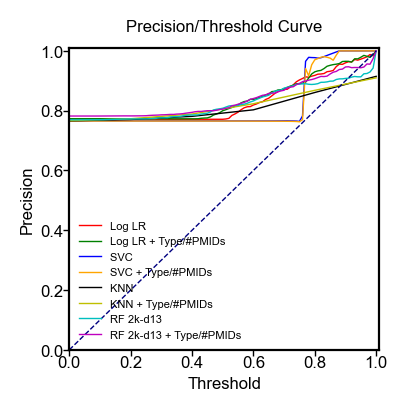

In [70]:
fig = plot_calibration(no_wt)
ax = fig.gca()

(0.5, 1.0)

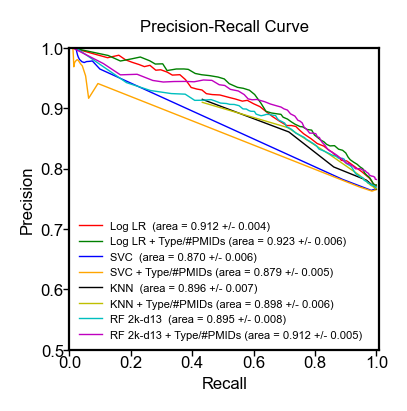

In [50]:
fig = plot_prc(no_wt)
ax = fig.gca()
ax.set_ylim([0.5, 1])

(0.5, 1.0)

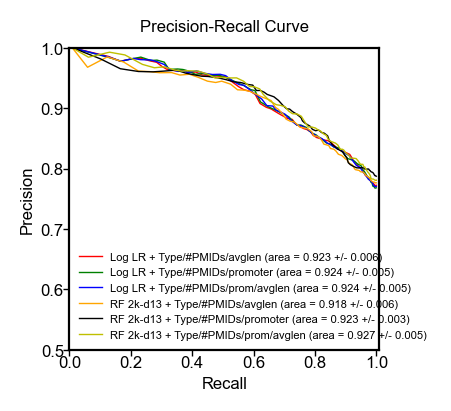

In [52]:
fig = plot_prc(no_wt_more_feats)
ax = fig.gca()
ax.set_ylim([0.5, 1])

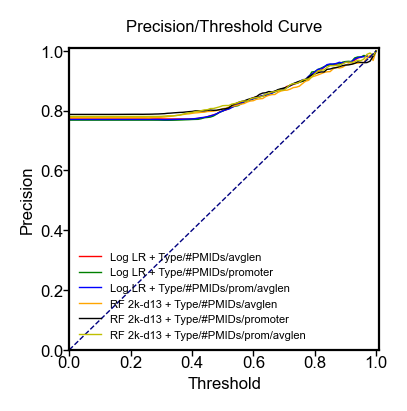

In [72]:
fig = plot_calibration(no_wt_more_feats)


(0.5, 1.0)

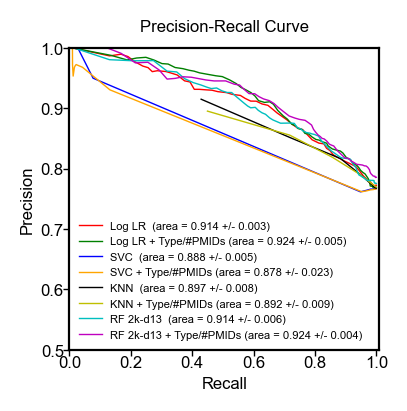

In [63]:
fig = plot_prc(supp_no_wt)
ax = fig.gca()
ax.set_ylim([0.5, 1])

(0.5, 1.0)

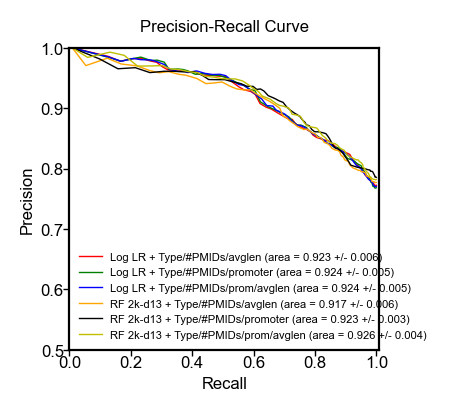

In [55]:
fig = plot_prc(supp_no_wt_more_feats)
ax = fig.gca()
ax.set_ylim([0.5, 1])

In [ ]:
fig = plot_prc(supp_no_wt)
ax = fig.gca()
ax.set_ylim([0.5, 1])

### Belief model runs:

Estimate each cell about 1 hr:

In [ ]:
source_list = reader_list

# Predictors
predictors = {'': {'use_stmt_type': False, 'use_num_members': False}, #'All features': x, }

#train_df = kge_df[reader_list + ['correct']]
models_ev = {
    'Belief Orig': BeliefModel(reader_list, use_supports=False),
}

no_wt_bel = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                              num_folds=10, cols_to_include=None, seed=seed)

# ---------------------------------
models_ev = {
    'Belief Orig': BeliefModel(reader_list, use_supports=True),
}

supp_no_wt_bel = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
              num_folds=10, cols_to_include=None, seed=seed, use_supports_train=True,
              use_supports_test=True, use_weights=False)

In [ ]:
source_list = all_sources

# Predictors
predictors = {'': {'use_stmt_type': False, 'use_num_members': False}, #'All features': x, }

#train_df = kge_df[reader_list + ['correct']]
models_ev = {
    'Belief Orig': BeliefModel(reader_list, use_supports=False),
}

no_wt_bel_dbs = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                              num_folds=10, cols_to_include=None, seed=seed)

# ---------------------------------
models_ev = {
    'Belief Orig': BeliefModel(reader_list, use_supports=True),
}

supp_no_wt_bel_dbs = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
              num_folds=10, cols_to_include=None, seed=seed, use_supports_train=True,
              use_supports_test=True, use_weights=False)

In [49]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

(0.5, 1.0)

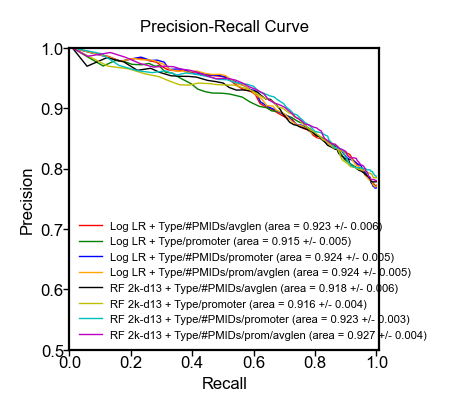

In [36]:
fig = plot_prc(no_wt_more_feats)
ax = fig.gca()
ax.set_ylim([0.5, 1])

With supports:

In [39]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

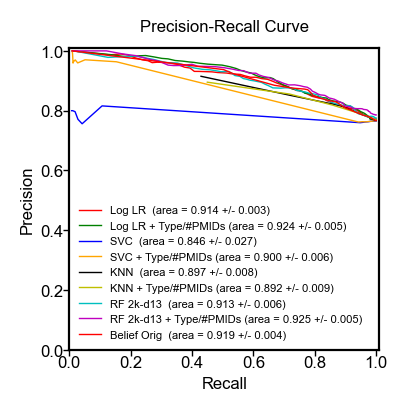

In [84]:
fig = plot_prc(supp_no_wt)

With additional features for LR and RF:

<IPython.core.display.Javascript object>


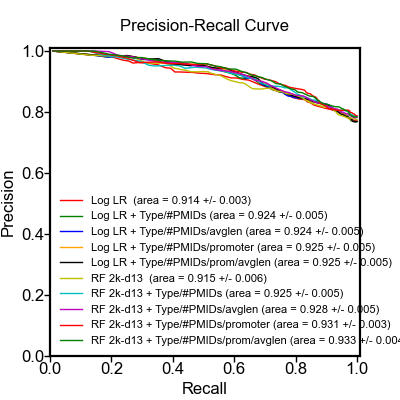

In [40]:
fig = plot_prc(supp_no_wt_feats)

Using all sources (including DBs) for logistic regression and RF:

<IPython.core.display.Javascript object>


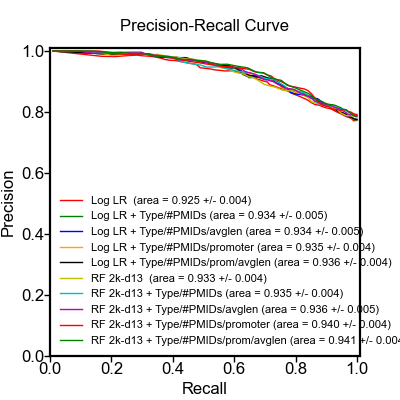

In [44]:
fig = plot_prc(supp_no_wt_feats_dbs)

Just the belief model, but learning the weights of DBs also:

In [46]:
source_list = all_sources

models_ev = {
    'Belief Orig': BeliefModel(source_list, use_supports=True),
}

predictors = {'': {'use_stmt_type': False, 'use_num_members': False}}


supp_no_wt_feats_dbs_bel = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                              num_folds=10, cols_to_include=None, seed=seed, use_supports_train=True,
                              use_supports_test=True, use_weights=False)


0it [00:00, ?it/s]

Readers ['sparser', 'signor', 'trips', 'trrust', 'isi', 'biopax', 'bel', 'rlimsp', 'medscan', 'hprd', 'reach'] Num_rows 1330 Pct corr 0.7654135338345864


INFO: [2021-07-19 17:08:51] model_fit - Burn in sampling...


sparser (644, 2)


INFO: [2021-07-19 17:09:08] model_fit - Main sampling...
INFO: [2021-07-19 17:09:25] model_fit - Done sampling.
INFO: [2021-07-19 17:09:25] model_fit - Burn in sampling...


signor (156, 2)


INFO: [2021-07-19 17:09:29] model_fit - Main sampling...
INFO: [2021-07-19 17:09:33] model_fit - Done sampling.
INFO: [2021-07-19 17:09:33] model_fit - Burn in sampling...


trips (384, 2)


INFO: [2021-07-19 17:09:43] model_fit - Main sampling...
INFO: [2021-07-19 17:09:54] model_fit - Done sampling.
INFO: [2021-07-19 17:09:54] model_fit - Burn in sampling...


trrust (7, 2)


INFO: [2021-07-19 17:09:54] model_fit - Main sampling...
INFO: [2021-07-19 17:09:54] model_fit - Done sampling.
INFO: [2021-07-19 17:09:54] model_fit - Burn in sampling...


isi (39, 2)


INFO: [2021-07-19 17:09:55] model_fit - Main sampling...
INFO: [2021-07-19 17:09:57] model_fit - Done sampling.
INFO: [2021-07-19 17:09:57] model_fit - Burn in sampling...


biopax (149, 2)


INFO: [2021-07-19 17:10:00] model_fit - Main sampling...
INFO: [2021-07-19 17:10:04] model_fit - Done sampling.
INFO: [2021-07-19 17:10:04] model_fit - Burn in sampling...


bel (134, 2)


INFO: [2021-07-19 17:10:08] model_fit - Main sampling...
INFO: [2021-07-19 17:10:11] model_fit - Done sampling.
INFO: [2021-07-19 17:10:11] model_fit - Burn in sampling...


rlimsp (221, 2)


INFO: [2021-07-19 17:10:17] model_fit - Main sampling...
INFO: [2021-07-19 17:10:23] model_fit - Done sampling.
INFO: [2021-07-19 17:10:23] model_fit - Burn in sampling...


medscan (713, 2)


INFO: [2021-07-19 17:10:42] model_fit - Main sampling...
INFO: [2021-07-19 17:11:02] model_fit - Done sampling.
INFO: [2021-07-19 17:11:02] model_fit - Burn in sampling...


hprd (202, 2)


INFO: [2021-07-19 17:11:06] model_fit - Main sampling...
INFO: [2021-07-19 17:11:12] model_fit - Done sampling.
INFO: [2021-07-19 17:11:12] model_fit - Burn in sampling...


reach (889, 2)


INFO: [2021-07-19 17:11:36] model_fit - Main sampling...
INFO: [2021-07-19 17:12:02] model_fit - Done sampling.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

1it [03:10, 190.59s/it]INFO: [2021-07-19 17:12:02] model_fit - Burn in sampling...


sparser (644, 2)


INFO: [2021-07-19 17:12:19] model_fit - Main sampling...
INFO: [2021-07-19 17:12:37] model_fit - Done sampling.
INFO: [2021-07-19 17:12:37] model_fit - Burn in sampling...


signor (161, 2)


INFO: [2021-07-19 17:12:41] model_fit - Main sampling...
INFO: [2021-07-19 17:12:45] model_fit - Done sampling.
INFO: [2021-07-19 17:12:45] model_fit - Burn in sampling...


trips (397, 2)


INFO: [2021-07-19 17:12:55] model_fit - Main sampling...
INFO: [2021-07-19 17:13:06] model_fit - Done sampling.
INFO: [2021-07-19 17:13:06] model_fit - Burn in sampling...


trrust (6, 2)


INFO: [2021-07-19 17:13:06] model_fit - Main sampling...
INFO: [2021-07-19 17:13:06] model_fit - Done sampling.
INFO: [2021-07-19 17:13:06] model_fit - Burn in sampling...


isi (33, 2)


INFO: [2021-07-19 17:13:07] model_fit - Main sampling...
INFO: [2021-07-19 17:13:08] model_fit - Done sampling.
INFO: [2021-07-19 17:13:08] model_fit - Burn in sampling...


biopax (157, 2)


INFO: [2021-07-19 17:13:12] model_fit - Main sampling...
INFO: [2021-07-19 17:13:16] model_fit - Done sampling.
INFO: [2021-07-19 17:13:16] model_fit - Burn in sampling...


bel (141, 2)


INFO: [2021-07-19 17:13:19] model_fit - Main sampling...
INFO: [2021-07-19 17:13:23] model_fit - Done sampling.
INFO: [2021-07-19 17:13:23] model_fit - Burn in sampling...


rlimsp (223, 2)


INFO: [2021-07-19 17:13:28] model_fit - Main sampling...
INFO: [2021-07-19 17:13:34] model_fit - Done sampling.
INFO: [2021-07-19 17:13:34] model_fit - Burn in sampling...


medscan (719, 2)


INFO: [2021-07-19 17:13:53] model_fit - Main sampling...
INFO: [2021-07-19 17:14:13] model_fit - Done sampling.
INFO: [2021-07-19 17:14:13] model_fit - Burn in sampling...


hprd (207, 2)


INFO: [2021-07-19 17:14:18] model_fit - Main sampling...
INFO: [2021-07-19 17:14:23] model_fit - Done sampling.
INFO: [2021-07-19 17:14:23] model_fit - Burn in sampling...


reach (890, 2)


INFO: [2021-07-19 17:14:47] model_fit - Main sampling...
INFO: [2021-07-19 17:15:12] model_fit - Done sampling.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

2it [06:20, 190.51s/it]INFO: [2021-07-19 17:15:12] model_fit - Burn in sampling...


sparser (640, 2)


INFO: [2021-07-19 17:15:29] model_fit - Main sampling...
INFO: [2021-07-19 17:15:47] model_fit - Done sampling.
INFO: [2021-07-19 17:15:47] model_fit - Burn in sampling...


signor (161, 2)


INFO: [2021-07-19 17:15:50] model_fit - Main sampling...
INFO: [2021-07-19 17:15:55] model_fit - Done sampling.
INFO: [2021-07-19 17:15:55] model_fit - Burn in sampling...


trips (389, 2)


INFO: [2021-07-19 17:16:05] model_fit - Main sampling...
INFO: [2021-07-19 17:16:15] model_fit - Done sampling.
INFO: [2021-07-19 17:16:15] model_fit - Burn in sampling...


trrust (7, 2)


INFO: [2021-07-19 17:16:16] model_fit - Main sampling...
INFO: [2021-07-19 17:16:16] model_fit - Done sampling.
INFO: [2021-07-19 17:16:16] model_fit - Burn in sampling...


isi (37, 2)


INFO: [2021-07-19 17:16:17] model_fit - Main sampling...
INFO: [2021-07-19 17:16:18] model_fit - Done sampling.
INFO: [2021-07-19 17:16:18] model_fit - Burn in sampling...


biopax (149, 2)


INFO: [2021-07-19 17:16:22] model_fit - Main sampling...
INFO: [2021-07-19 17:16:25] model_fit - Done sampling.
INFO: [2021-07-19 17:16:25] model_fit - Burn in sampling...


bel (138, 2)


INFO: [2021-07-19 17:16:29] model_fit - Main sampling...
INFO: [2021-07-19 17:16:32] model_fit - Done sampling.
INFO: [2021-07-19 17:16:32] model_fit - Burn in sampling...


rlimsp (224, 2)


INFO: [2021-07-19 17:16:37] model_fit - Main sampling...
INFO: [2021-07-19 17:16:43] model_fit - Done sampling.
INFO: [2021-07-19 17:16:43] model_fit - Burn in sampling...


medscan (716, 2)


INFO: [2021-07-19 17:17:02] model_fit - Main sampling...
INFO: [2021-07-19 17:17:22] model_fit - Done sampling.
INFO: [2021-07-19 17:17:22] model_fit - Burn in sampling...


hprd (201, 2)


INFO: [2021-07-19 17:17:26] model_fit - Main sampling...
INFO: [2021-07-19 17:17:32] model_fit - Done sampling.
INFO: [2021-07-19 17:17:32] model_fit - Burn in sampling...


reach (892, 2)


INFO: [2021-07-19 17:17:56] model_fit - Main sampling...
INFO: [2021-07-19 17:18:21] model_fit - Done sampling.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

3it [09:29, 190.08s/it]INFO: [2021-07-19 17:18:21] model_fit - Burn in sampling...


sparser (655, 2)


INFO: [2021-07-19 17:18:39] model_fit - Main sampling...
INFO: [2021-07-19 17:18:58] model_fit - Done sampling.
INFO: [2021-07-19 17:18:58] model_fit - Burn in sampling...


signor (163, 2)


INFO: [2021-07-19 17:19:02] model_fit - Main sampling...
INFO: [2021-07-19 17:19:07] model_fit - Done sampling.
INFO: [2021-07-19 17:19:07] model_fit - Burn in sampling...


trips (408, 2)


INFO: [2021-07-19 17:19:17] model_fit - Main sampling...
INFO: [2021-07-19 17:19:28] model_fit - Done sampling.
INFO: [2021-07-19 17:19:28] model_fit - Burn in sampling...


trrust (8, 2)


INFO: [2021-07-19 17:19:28] model_fit - Main sampling...
INFO: [2021-07-19 17:19:28] model_fit - Done sampling.
INFO: [2021-07-19 17:19:28] model_fit - Burn in sampling...


isi (39, 2)


INFO: [2021-07-19 17:19:30] model_fit - Main sampling...
INFO: [2021-07-19 17:19:31] model_fit - Done sampling.
INFO: [2021-07-19 17:19:31] model_fit - Burn in sampling...


biopax (152, 2)


INFO: [2021-07-19 17:19:34] model_fit - Main sampling...
INFO: [2021-07-19 17:19:38] model_fit - Done sampling.
INFO: [2021-07-19 17:19:38] model_fit - Burn in sampling...


bel (149, 2)


INFO: [2021-07-19 17:19:42] model_fit - Main sampling...
INFO: [2021-07-19 17:19:46] model_fit - Done sampling.
INFO: [2021-07-19 17:19:46] model_fit - Burn in sampling...


rlimsp (227, 2)


INFO: [2021-07-19 17:19:51] model_fit - Main sampling...
INFO: [2021-07-19 17:19:57] model_fit - Done sampling.
INFO: [2021-07-19 17:19:57] model_fit - Burn in sampling...


medscan (727, 2)


INFO: [2021-07-19 17:20:16] model_fit - Main sampling...
INFO: [2021-07-19 17:20:36] model_fit - Done sampling.
INFO: [2021-07-19 17:20:36] model_fit - Burn in sampling...


hprd (208, 2)


INFO: [2021-07-19 17:20:42] model_fit - Main sampling...
INFO: [2021-07-19 17:20:47] model_fit - Done sampling.
INFO: [2021-07-19 17:20:47] model_fit - Burn in sampling...


reach (883, 2)


INFO: [2021-07-19 17:21:11] model_fit - Main sampling...
INFO: [2021-07-19 17:21:35] model_fit - Done sampling.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

4it [12:44, 191.28s/it]INFO: [2021-07-19 17:21:35] model_fit - Burn in sampling...


sparser (648, 2)


INFO: [2021-07-19 17:21:52] model_fit - Main sampling...
INFO: [2021-07-19 17:22:10] model_fit - Done sampling.
INFO: [2021-07-19 17:22:10] model_fit - Burn in sampling...


signor (157, 2)


INFO: [2021-07-19 17:22:14] model_fit - Main sampling...
INFO: [2021-07-19 17:22:18] model_fit - Done sampling.
INFO: [2021-07-19 17:22:18] model_fit - Burn in sampling...


trips (403, 2)


INFO: [2021-07-19 17:22:28] model_fit - Main sampling...
INFO: [2021-07-19 17:22:39] model_fit - Done sampling.
INFO: [2021-07-19 17:22:39] model_fit - Burn in sampling...


trrust (8, 2)


INFO: [2021-07-19 17:22:39] model_fit - Main sampling...
INFO: [2021-07-19 17:22:39] model_fit - Done sampling.
INFO: [2021-07-19 17:22:39] model_fit - Burn in sampling...


isi (35, 2)


INFO: [2021-07-19 17:22:40] model_fit - Main sampling...
INFO: [2021-07-19 17:22:41] model_fit - Done sampling.
INFO: [2021-07-19 17:22:41] model_fit - Burn in sampling...


biopax (153, 2)


INFO: [2021-07-19 17:22:45] model_fit - Main sampling...
INFO: [2021-07-19 17:22:49] model_fit - Done sampling.
INFO: [2021-07-19 17:22:49] model_fit - Burn in sampling...


bel (140, 2)


INFO: [2021-07-19 17:22:52] model_fit - Main sampling...
INFO: [2021-07-19 17:22:56] model_fit - Done sampling.
INFO: [2021-07-19 17:22:56] model_fit - Burn in sampling...


rlimsp (231, 2)


INFO: [2021-07-19 17:23:02] model_fit - Main sampling...
INFO: [2021-07-19 17:23:08] model_fit - Done sampling.
INFO: [2021-07-19 17:23:08] model_fit - Burn in sampling...


medscan (714, 2)


INFO: [2021-07-19 17:23:27] model_fit - Main sampling...
INFO: [2021-07-19 17:23:45] model_fit - Done sampling.
INFO: [2021-07-19 17:23:45] model_fit - Burn in sampling...


hprd (203, 2)


INFO: [2021-07-19 17:23:50] model_fit - Main sampling...
INFO: [2021-07-19 17:23:56] model_fit - Done sampling.
INFO: [2021-07-19 17:23:56] model_fit - Burn in sampling...


reach (892, 2)


INFO: [2021-07-19 17:24:20] model_fit - Main sampling...
INFO: [2021-07-19 17:24:45] model_fit - Done sampling.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

5it [15:53, 190.79s/it]INFO: [2021-07-19 17:24:45] model_fit - Burn in sampling...


sparser (648, 2)


INFO: [2021-07-19 17:25:03] model_fit - Main sampling...
INFO: [2021-07-19 17:25:20] model_fit - Done sampling.
INFO: [2021-07-19 17:25:20] model_fit - Burn in sampling...


signor (161, 2)


INFO: [2021-07-19 17:25:24] model_fit - Main sampling...
INFO: [2021-07-19 17:25:28] model_fit - Done sampling.
INFO: [2021-07-19 17:25:28] model_fit - Burn in sampling...


trips (387, 2)


INFO: [2021-07-19 17:25:37] model_fit - Main sampling...
INFO: [2021-07-19 17:25:48] model_fit - Done sampling.
INFO: [2021-07-19 17:25:48] model_fit - Burn in sampling...


trrust (8, 2)


INFO: [2021-07-19 17:25:48] model_fit - Main sampling...
INFO: [2021-07-19 17:25:49] model_fit - Done sampling.
INFO: [2021-07-19 17:25:49] model_fit - Burn in sampling...


isi (37, 2)


INFO: [2021-07-19 17:25:50] model_fit - Main sampling...
INFO: [2021-07-19 17:25:51] model_fit - Done sampling.
INFO: [2021-07-19 17:25:51] model_fit - Burn in sampling...


biopax (154, 2)


INFO: [2021-07-19 17:25:55] model_fit - Main sampling...
INFO: [2021-07-19 17:25:58] model_fit - Done sampling.
INFO: [2021-07-19 17:25:58] model_fit - Burn in sampling...


bel (141, 2)


INFO: [2021-07-19 17:26:02] model_fit - Main sampling...
INFO: [2021-07-19 17:26:06] model_fit - Done sampling.
INFO: [2021-07-19 17:26:06] model_fit - Burn in sampling...


rlimsp (233, 2)


INFO: [2021-07-19 17:26:12] model_fit - Main sampling...
INFO: [2021-07-19 17:26:18] model_fit - Done sampling.
INFO: [2021-07-19 17:26:18] model_fit - Burn in sampling...


medscan (712, 2)


INFO: [2021-07-19 17:26:37] model_fit - Main sampling...
INFO: [2021-07-19 17:26:56] model_fit - Done sampling.
INFO: [2021-07-19 17:26:56] model_fit - Burn in sampling...


hprd (203, 2)


INFO: [2021-07-19 17:27:01] model_fit - Main sampling...
INFO: [2021-07-19 17:27:06] model_fit - Done sampling.
INFO: [2021-07-19 17:27:06] model_fit - Burn in sampling...


reach (882, 2)


INFO: [2021-07-19 17:27:31] model_fit - Main sampling...
INFO: [2021-07-19 17:27:56] model_fit - Done sampling.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

6it [19:04, 190.79s/it]INFO: [2021-07-19 17:27:56] model_fit - Burn in sampling...


sparser (649, 2)


INFO: [2021-07-19 17:28:13] model_fit - Main sampling...
INFO: [2021-07-19 17:28:31] model_fit - Done sampling.
INFO: [2021-07-19 17:28:31] model_fit - Burn in sampling...


signor (160, 2)


INFO: [2021-07-19 17:28:35] model_fit - Main sampling...
INFO: [2021-07-19 17:28:39] model_fit - Done sampling.
INFO: [2021-07-19 17:28:39] model_fit - Burn in sampling...


trips (403, 2)


INFO: [2021-07-19 17:28:49] model_fit - Main sampling...
INFO: [2021-07-19 17:29:01] model_fit - Done sampling.
INFO: [2021-07-19 17:29:01] model_fit - Burn in sampling...


trrust (7, 2)


INFO: [2021-07-19 17:29:01] model_fit - Main sampling...
INFO: [2021-07-19 17:29:01] model_fit - Done sampling.
INFO: [2021-07-19 17:29:01] model_fit - Burn in sampling...


isi (37, 2)


INFO: [2021-07-19 17:29:02] model_fit - Main sampling...
INFO: [2021-07-19 17:29:03] model_fit - Done sampling.
INFO: [2021-07-19 17:29:03] model_fit - Burn in sampling...


biopax (155, 2)


INFO: [2021-07-19 17:29:07] model_fit - Main sampling...
INFO: [2021-07-19 17:29:11] model_fit - Done sampling.
INFO: [2021-07-19 17:29:11] model_fit - Burn in sampling...


bel (142, 2)


INFO: [2021-07-19 17:29:14] model_fit - Main sampling...
INFO: [2021-07-19 17:29:18] model_fit - Done sampling.
INFO: [2021-07-19 17:29:18] model_fit - Burn in sampling...


rlimsp (236, 2)


INFO: [2021-07-19 17:29:24] model_fit - Main sampling...
INFO: [2021-07-19 17:29:30] model_fit - Done sampling.
INFO: [2021-07-19 17:29:30] model_fit - Burn in sampling...


medscan (704, 2)


INFO: [2021-07-19 17:29:48] model_fit - Main sampling...
INFO: [2021-07-19 17:30:07] model_fit - Done sampling.
INFO: [2021-07-19 17:30:07] model_fit - Burn in sampling...


hprd (202, 2)


INFO: [2021-07-19 17:30:12] model_fit - Main sampling...
INFO: [2021-07-19 17:30:17] model_fit - Done sampling.
INFO: [2021-07-19 17:30:17] model_fit - Burn in sampling...


reach (875, 2)


INFO: [2021-07-19 17:30:42] model_fit - Main sampling...
INFO: [2021-07-19 17:31:07] model_fit - Done sampling.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

7it [22:15, 190.92s/it]INFO: [2021-07-19 17:31:07] model_fit - Burn in sampling...


sparser (648, 2)


INFO: [2021-07-19 17:31:24] model_fit - Main sampling...
INFO: [2021-07-19 17:31:42] model_fit - Done sampling.
INFO: [2021-07-19 17:31:42] model_fit - Burn in sampling...


signor (163, 2)


INFO: [2021-07-19 17:31:46] model_fit - Main sampling...
INFO: [2021-07-19 17:31:50] model_fit - Done sampling.
INFO: [2021-07-19 17:31:50] model_fit - Burn in sampling...


trips (399, 2)


INFO: [2021-07-19 17:32:01] model_fit - Main sampling...
INFO: [2021-07-19 17:32:11] model_fit - Done sampling.
INFO: [2021-07-19 17:32:11] model_fit - Burn in sampling...


trrust (8, 2)


INFO: [2021-07-19 17:32:12] model_fit - Main sampling...
INFO: [2021-07-19 17:32:12] model_fit - Done sampling.
INFO: [2021-07-19 17:32:12] model_fit - Burn in sampling...


isi (37, 2)


INFO: [2021-07-19 17:32:13] model_fit - Main sampling...
INFO: [2021-07-19 17:32:14] model_fit - Done sampling.
INFO: [2021-07-19 17:32:14] model_fit - Burn in sampling...


biopax (157, 2)


INFO: [2021-07-19 17:32:18] model_fit - Main sampling...
INFO: [2021-07-19 17:32:22] model_fit - Done sampling.
INFO: [2021-07-19 17:32:22] model_fit - Burn in sampling...


bel (144, 2)


INFO: [2021-07-19 17:32:25] model_fit - Main sampling...
INFO: [2021-07-19 17:32:29] model_fit - Done sampling.
INFO: [2021-07-19 17:32:29] model_fit - Burn in sampling...


rlimsp (229, 2)


INFO: [2021-07-19 17:32:35] model_fit - Main sampling...
INFO: [2021-07-19 17:32:41] model_fit - Done sampling.
INFO: [2021-07-19 17:32:41] model_fit - Burn in sampling...


medscan (715, 2)


INFO: [2021-07-19 17:33:00] model_fit - Main sampling...
INFO: [2021-07-19 17:33:20] model_fit - Done sampling.
INFO: [2021-07-19 17:33:20] model_fit - Burn in sampling...


hprd (207, 2)


INFO: [2021-07-19 17:33:25] model_fit - Main sampling...
INFO: [2021-07-19 17:33:30] model_fit - Done sampling.
INFO: [2021-07-19 17:33:30] model_fit - Burn in sampling...


reach (886, 2)


INFO: [2021-07-19 17:33:54] model_fit - Main sampling...
INFO: [2021-07-19 17:34:19] model_fit - Done sampling.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

8it [25:27, 191.17s/it]INFO: [2021-07-19 17:34:19] model_fit - Burn in sampling...


sparser (649, 2)


INFO: [2021-07-19 17:34:36] model_fit - Main sampling...
INFO: [2021-07-19 17:34:53] model_fit - Done sampling.
INFO: [2021-07-19 17:34:53] model_fit - Burn in sampling...


signor (161, 2)


INFO: [2021-07-19 17:34:57] model_fit - Main sampling...
INFO: [2021-07-19 17:35:01] model_fit - Done sampling.
INFO: [2021-07-19 17:35:01] model_fit - Burn in sampling...


trips (396, 2)


INFO: [2021-07-19 17:35:12] model_fit - Main sampling...
INFO: [2021-07-19 17:35:22] model_fit - Done sampling.
INFO: [2021-07-19 17:35:22] model_fit - Burn in sampling...


trrust (8, 2)


INFO: [2021-07-19 17:35:23] model_fit - Main sampling...
INFO: [2021-07-19 17:35:23] model_fit - Done sampling.
INFO: [2021-07-19 17:35:23] model_fit - Burn in sampling...


isi (38, 2)


INFO: [2021-07-19 17:35:24] model_fit - Main sampling...
INFO: [2021-07-19 17:35:25] model_fit - Done sampling.
INFO: [2021-07-19 17:35:25] model_fit - Burn in sampling...


biopax (153, 2)


INFO: [2021-07-19 17:35:29] model_fit - Main sampling...
INFO: [2021-07-19 17:35:33] model_fit - Done sampling.
INFO: [2021-07-19 17:35:33] model_fit - Burn in sampling...


bel (146, 2)


INFO: [2021-07-19 17:35:36] model_fit - Main sampling...
INFO: [2021-07-19 17:35:40] model_fit - Done sampling.
INFO: [2021-07-19 17:35:40] model_fit - Burn in sampling...


rlimsp (221, 2)


INFO: [2021-07-19 17:35:45] model_fit - Main sampling...
INFO: [2021-07-19 17:35:51] model_fit - Done sampling.
INFO: [2021-07-19 17:35:51] model_fit - Burn in sampling...


medscan (721, 2)


INFO: [2021-07-19 17:36:10] model_fit - Main sampling...
INFO: [2021-07-19 17:36:30] model_fit - Done sampling.
INFO: [2021-07-19 17:36:30] model_fit - Burn in sampling...


hprd (203, 2)


INFO: [2021-07-19 17:36:35] model_fit - Main sampling...
INFO: [2021-07-19 17:36:40] model_fit - Done sampling.
INFO: [2021-07-19 17:36:40] model_fit - Burn in sampling...


reach (885, 2)


INFO: [2021-07-19 17:37:04] model_fit - Main sampling...
INFO: [2021-07-19 17:37:29] model_fit - Done sampling.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

9it [28:37, 190.90s/it]INFO: [2021-07-19 17:37:29] model_fit - Burn in sampling...


sparser (655, 2)


INFO: [2021-07-19 17:37:46] model_fit - Main sampling...
INFO: [2021-07-19 17:38:04] model_fit - Done sampling.
INFO: [2021-07-19 17:38:04] model_fit - Burn in sampling...


signor (159, 2)


INFO: [2021-07-19 17:38:08] model_fit - Main sampling...
INFO: [2021-07-19 17:38:12] model_fit - Done sampling.
INFO: [2021-07-19 17:38:12] model_fit - Burn in sampling...


trips (385, 2)


INFO: [2021-07-19 17:38:22] model_fit - Main sampling...
INFO: [2021-07-19 17:38:32] model_fit - Done sampling.
INFO: [2021-07-19 17:38:32] model_fit - Burn in sampling...


trrust (5, 2)


INFO: [2021-07-19 17:38:32] model_fit - Main sampling...
INFO: [2021-07-19 17:38:32] model_fit - Done sampling.
INFO: [2021-07-19 17:38:32] model_fit - Burn in sampling...


isi (37, 2)


INFO: [2021-07-19 17:38:33] model_fit - Main sampling...
INFO: [2021-07-19 17:38:35] model_fit - Done sampling.
INFO: [2021-07-19 17:38:35] model_fit - Burn in sampling...


biopax (151, 2)


INFO: [2021-07-19 17:38:38] model_fit - Main sampling...
INFO: [2021-07-19 17:38:42] model_fit - Done sampling.
INFO: [2021-07-19 17:38:42] model_fit - Burn in sampling...


bel (138, 2)


INFO: [2021-07-19 17:38:45] model_fit - Main sampling...
INFO: [2021-07-19 17:38:49] model_fit - Done sampling.
INFO: [2021-07-19 17:38:49] model_fit - Burn in sampling...


rlimsp (223, 2)


INFO: [2021-07-19 17:38:54] model_fit - Main sampling...
INFO: [2021-07-19 17:39:00] model_fit - Done sampling.
INFO: [2021-07-19 17:39:00] model_fit - Burn in sampling...


medscan (714, 2)


INFO: [2021-07-19 17:39:19] model_fit - Main sampling...
INFO: [2021-07-19 17:39:38] model_fit - Done sampling.
INFO: [2021-07-19 17:39:38] model_fit - Burn in sampling...


hprd (207, 2)


INFO: [2021-07-19 17:39:43] model_fit - Main sampling...
INFO: [2021-07-19 17:39:48] model_fit - Done sampling.
INFO: [2021-07-19 17:39:48] model_fit - Burn in sampling...


reach (891, 2)


INFO: [2021-07-19 17:40:12] model_fit - Main sampling...
INFO: [2021-07-19 17:40:37] model_fit - Done sampling.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)

10it [31:46, 190.62s/it]


<IPython.core.display.Javascript object>


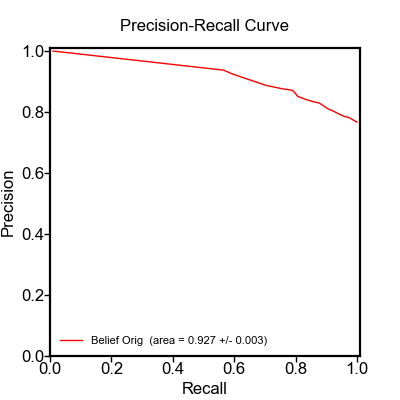

In [47]:
fig = plot_prc(supp_no_wt_feats_dbs_bel)

## Summary PRC plot

In [37]:
no_wt.keys()

NameError: name 'no_wt' is not defined

## Measure effect of sample weights

In [32]:
#has_supp_hashes = [s.get_hash() for s in cur_stmts if s.supports]
#has_supp_df = cur_df[cur_df.stmt_hash.isin(has_supp_hashes)]

In [33]:
#has_supp_df

In [34]:
"""for correct_val in (0, 1):
    stmt_hashes = cur_df[cur_df.correct == correct_val].stmt_hash.values
    #supp_by_stmts = [sb_stmt for stmt_hash in stmt_hashes
    #                             for sb_stmt in all_stmts_dict[stmt_hash].supported_by
    #                             if None not in sb_stmt.agent_list()]    
    supp_stmts = [sb_stmt for stmt_hash in stmt_hashes
                              for sb_stmt in all_stmts_dict[stmt_hash].supports
                              if None not in sb_stmt.agent_list()]
    supp_hashes[correct_val] = {'supports': [s.get_hash() for s in supp_stmts],
                                'supported_by': [s.get_hash() for s  in supp_by_stmts]}
"""

"for correct_val in (0, 1):\n    stmt_hashes = cur_df[cur_df.correct == correct_val].stmt_hash.values\n    #supp_by_stmts = [sb_stmt for stmt_hash in stmt_hashes\n    #                             for sb_stmt in all_stmts_dict[stmt_hash].supported_by\n    #                             if None not in sb_stmt.agent_list()]    \n    supp_stmts = [sb_stmt for stmt_hash in stmt_hashes\n                              for sb_stmt in all_stmts_dict[stmt_hash].supports\n                              if None not in sb_stmt.agent_list()]\n    supp_hashes[correct_val] = {'supports': [s.get_hash() for s in supp_stmts],\n                                'supported_by': [s.get_hash() for s  in supp_by_stmts]}\n"

First, no supports:

In [43]:
models_ev = {
    'Log LR': LogLogisticRegression(),    
    #'SVC': SVC(probability=True),
    #'KNN': KNeighborsClassifier(),    
    #'RF 1k-d7': RandomForestClassifier(n_estimators=1000, max_depth=7),
    #'RF 1k-d10': RandomForestClassifier(n_estimators=1000, max_depth=10),
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
    'Belief Orig': BeliefModel(reader_list, use_supports=False),
}

no_supp_wt = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                              num_folds=10, cols_to_include=None, seed=seed, use_weights=True)


0it [00:00, ?it/s]INFO: [2021-07-14 15:24:55] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:24:55] indra.belief.skl - source_list does not include all source_apis in the statement data.


Readers ['reach', 'sparser', 'medscan', 'rlimsp', 'trips'] Num_rows 1330 Pct corr 0.7654135338345864


INFO: [2021-07-14 15:24:55] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:24:55] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:24:55] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:24:55] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:24:55] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:24:58] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:24:58] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:24:59] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:25:02] indra.belief.skl - source_list does not include all 

INFO: [2021-07-14 15:25:39] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:25:39] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:25:39] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:25:39] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:25:39] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:25:39] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:25:42] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:25:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:25:43] indra.belief.skl - source_list does not include all 

In [44]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

In [45]:
#no_supp_wt_belief = no_supp_wt
no_supp_wt.update(no_supp_wt_belief)

(0.4, 1.0)

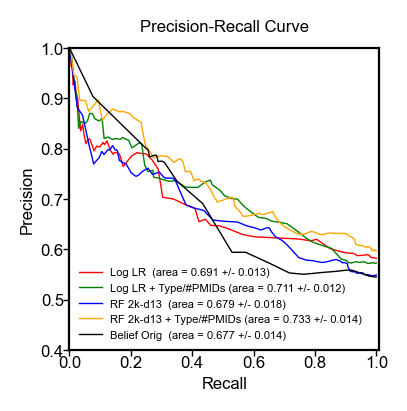

In [47]:
fig = plot_prc(no_supp_wt)
ax = fig.gca()
ax.set_ylim([0.4, 1])

In [49]:
models_ev = {
    'Log LR': LogLogisticRegression(),    
    #'SVC': SVC(probability=True),
    #'KNN': KNeighborsClassifier(),    
    #'RF 1k-d7': RandomForestClassifier(n_estimators=1000, max_depth=7),
    #'RF 1k-d10': RandomForestClassifier(n_estimators=1000, max_depth=10),
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
    'Belief Orig': BeliefModel(reader_list, use_supports=True),
}

supp_wt = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                              num_folds=10, cols_to_include=None, seed=seed, use_supports_train=True,
                              use_supports_test=True, use_weights=True)

0it [00:00, ?it/s]

Readers ['reach', 'sparser', 'medscan', 'rlimsp', 'trips'] Num_rows 1330 Pct corr 0.7654135338345864


INFO: [2021-07-14 15:35:12] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:35:12] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:35:12] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:35:12] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:35:12] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:35:12] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:35:12] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:35:15] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:35:16] indra.belief.skl - source_list does not include all 

reach (889, 2)


INFO: [2021-07-14 15:35:47] model_fit - Main sampling...
INFO: [2021-07-14 15:36:15] model_fit - Done sampling.
INFO: [2021-07-14 15:36:15] model_fit - Burn in sampling...


sparser (644, 2)


INFO: [2021-07-14 15:36:33] model_fit - Main sampling...
INFO: [2021-07-14 15:36:51] model_fit - Done sampling.
INFO: [2021-07-14 15:36:51] model_fit - Burn in sampling...


medscan (713, 2)


INFO: [2021-07-14 15:37:12] model_fit - Main sampling...
INFO: [2021-07-14 15:37:33] model_fit - Done sampling.
INFO: [2021-07-14 15:37:33] model_fit - Burn in sampling...


rlimsp (221, 2)


INFO: [2021-07-14 15:37:39] model_fit - Main sampling...
INFO: [2021-07-14 15:37:45] model_fit - Done sampling.
INFO: [2021-07-14 15:37:45] model_fit - Burn in sampling...


trips (384, 2)


INFO: [2021-07-14 15:37:56] model_fit - Main sampling...
INFO: [2021-07-14 15:38:11] model_fit - Done sampling.
INFO: [2021-07-14 15:38:11] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:38:11] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
1it [02:59, 179.16s/it]INFO: [2021-07-14 15:38:11] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:38:11] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:38:11] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:38:11] indra.belief.skl - source_list does not includ

reach (890, 2)


INFO: [2021-07-14 15:38:46] model_fit - Main sampling...
INFO: [2021-07-14 15:39:14] model_fit - Done sampling.
INFO: [2021-07-14 15:39:14] model_fit - Burn in sampling...


sparser (644, 2)


INFO: [2021-07-14 15:39:34] model_fit - Main sampling...
INFO: [2021-07-14 15:39:52] model_fit - Done sampling.
INFO: [2021-07-14 15:39:52] model_fit - Burn in sampling...


medscan (719, 2)


INFO: [2021-07-14 15:40:15] model_fit - Main sampling...
INFO: [2021-07-14 15:40:39] model_fit - Done sampling.
INFO: [2021-07-14 15:40:39] model_fit - Burn in sampling...


rlimsp (223, 2)


INFO: [2021-07-14 15:40:46] model_fit - Main sampling...
INFO: [2021-07-14 15:40:52] model_fit - Done sampling.
INFO: [2021-07-14 15:40:52] model_fit - Burn in sampling...


trips (397, 2)


INFO: [2021-07-14 15:41:03] model_fit - Main sampling...
INFO: [2021-07-14 15:41:15] model_fit - Done sampling.
INFO: [2021-07-14 15:41:15] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:41:15] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
2it [06:03, 180.76s/it]INFO: [2021-07-14 15:41:16] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:41:16] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:41:16] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:41:16] indra.belief.skl - source_list does not includ

reach (892, 2)


INFO: [2021-07-14 15:41:51] model_fit - Main sampling...
INFO: [2021-07-14 15:42:18] model_fit - Done sampling.
INFO: [2021-07-14 15:42:18] model_fit - Burn in sampling...


sparser (640, 2)


INFO: [2021-07-14 15:42:37] model_fit - Main sampling...
INFO: [2021-07-14 15:42:56] model_fit - Done sampling.
INFO: [2021-07-14 15:42:56] model_fit - Burn in sampling...


medscan (716, 2)


INFO: [2021-07-14 15:43:18] model_fit - Main sampling...
INFO: [2021-07-14 15:43:41] model_fit - Done sampling.
INFO: [2021-07-14 15:43:41] model_fit - Burn in sampling...


rlimsp (224, 2)


INFO: [2021-07-14 15:43:47] model_fit - Main sampling...
INFO: [2021-07-14 15:43:53] model_fit - Done sampling.
INFO: [2021-07-14 15:43:53] model_fit - Burn in sampling...


trips (389, 2)


INFO: [2021-07-14 15:44:05] model_fit - Main sampling...
INFO: [2021-07-14 15:44:17] model_fit - Done sampling.
INFO: [2021-07-14 15:44:17] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:44:17] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
3it [09:05, 180.97s/it]INFO: [2021-07-14 15:44:17] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:44:17] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:44:17] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:44:17] indra.belief.skl - source_list does not includ

reach (883, 2)


INFO: [2021-07-14 15:44:54] model_fit - Main sampling...
INFO: [2021-07-14 15:45:24] model_fit - Done sampling.
INFO: [2021-07-14 15:45:24] model_fit - Burn in sampling...


sparser (655, 2)


INFO: [2021-07-14 15:45:44] model_fit - Main sampling...
INFO: [2021-07-14 15:46:05] model_fit - Done sampling.
INFO: [2021-07-14 15:46:05] model_fit - Burn in sampling...


medscan (727, 2)


INFO: [2021-07-14 15:46:26] model_fit - Main sampling...
INFO: [2021-07-14 15:46:49] model_fit - Done sampling.
INFO: [2021-07-14 15:46:49] model_fit - Burn in sampling...


rlimsp (227, 2)


INFO: [2021-07-14 15:46:55] model_fit - Main sampling...
INFO: [2021-07-14 15:47:02] model_fit - Done sampling.
INFO: [2021-07-14 15:47:02] model_fit - Burn in sampling...


trips (408, 2)


INFO: [2021-07-14 15:47:14] model_fit - Main sampling...
INFO: [2021-07-14 15:47:26] model_fit - Done sampling.
INFO: [2021-07-14 15:47:26] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:47:26] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
4it [12:14, 183.46s/it]INFO: [2021-07-14 15:47:26] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:47:26] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:47:26] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:47:27] indra.belief.skl - source_list does not includ

reach (892, 2)


INFO: [2021-07-14 15:48:02] model_fit - Main sampling...
INFO: [2021-07-14 15:48:31] model_fit - Done sampling.
INFO: [2021-07-14 15:48:31] model_fit - Burn in sampling...


sparser (648, 2)


INFO: [2021-07-14 15:48:50] model_fit - Main sampling...
INFO: [2021-07-14 15:49:10] model_fit - Done sampling.
INFO: [2021-07-14 15:49:10] model_fit - Burn in sampling...


medscan (714, 2)


INFO: [2021-07-14 15:49:32] model_fit - Main sampling...
INFO: [2021-07-14 15:49:54] model_fit - Done sampling.
INFO: [2021-07-14 15:49:54] model_fit - Burn in sampling...


rlimsp (231, 2)


INFO: [2021-07-14 15:50:00] model_fit - Main sampling...
INFO: [2021-07-14 15:50:07] model_fit - Done sampling.
INFO: [2021-07-14 15:50:07] model_fit - Burn in sampling...


trips (403, 2)


INFO: [2021-07-14 15:50:19] model_fit - Main sampling...
INFO: [2021-07-14 15:50:32] model_fit - Done sampling.
INFO: [2021-07-14 15:50:32] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:50:32] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
5it [15:20, 184.11s/it]INFO: [2021-07-14 15:50:32] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:50:32] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:50:32] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:50:32] indra.belief.skl - source_list does not includ

reach (882, 2)


INFO: [2021-07-14 15:51:09] model_fit - Main sampling...
INFO: [2021-07-14 15:51:38] model_fit - Done sampling.
INFO: [2021-07-14 15:51:38] model_fit - Burn in sampling...


sparser (648, 2)


INFO: [2021-07-14 15:51:59] model_fit - Main sampling...
INFO: [2021-07-14 15:52:21] model_fit - Done sampling.
INFO: [2021-07-14 15:52:21] model_fit - Burn in sampling...


medscan (712, 2)


INFO: [2021-07-14 15:52:41] model_fit - Main sampling...
INFO: [2021-07-14 15:53:03] model_fit - Done sampling.
INFO: [2021-07-14 15:53:03] model_fit - Burn in sampling...


rlimsp (233, 2)


INFO: [2021-07-14 15:53:09] model_fit - Main sampling...
INFO: [2021-07-14 15:53:16] model_fit - Done sampling.
INFO: [2021-07-14 15:53:16] model_fit - Burn in sampling...


trips (387, 2)


INFO: [2021-07-14 15:53:28] model_fit - Main sampling...
INFO: [2021-07-14 15:53:40] model_fit - Done sampling.
INFO: [2021-07-14 15:53:40] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:53:40] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
6it [18:28, 185.30s/it]INFO: [2021-07-14 15:53:40] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:53:40] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:53:40] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:53:40] indra.belief.skl - source_list does not includ

reach (875, 2)


INFO: [2021-07-14 15:54:16] model_fit - Main sampling...
INFO: [2021-07-14 15:54:44] model_fit - Done sampling.
INFO: [2021-07-14 15:54:44] model_fit - Burn in sampling...


sparser (649, 2)


INFO: [2021-07-14 15:55:04] model_fit - Main sampling...
INFO: [2021-07-14 15:55:25] model_fit - Done sampling.
INFO: [2021-07-14 15:55:25] model_fit - Burn in sampling...


medscan (704, 2)


INFO: [2021-07-14 15:55:46] model_fit - Main sampling...
INFO: [2021-07-14 15:56:08] model_fit - Done sampling.
INFO: [2021-07-14 15:56:08] model_fit - Burn in sampling...


rlimsp (236, 2)


INFO: [2021-07-14 15:56:14] model_fit - Main sampling...
INFO: [2021-07-14 15:56:21] model_fit - Done sampling.
INFO: [2021-07-14 15:56:21] model_fit - Burn in sampling...


trips (403, 2)


INFO: [2021-07-14 15:56:32] model_fit - Main sampling...
INFO: [2021-07-14 15:56:45] model_fit - Done sampling.
INFO: [2021-07-14 15:56:45] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:56:45] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
7it [21:32, 185.15s/it]INFO: [2021-07-14 15:56:45] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:56:45] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:56:45] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:56:45] indra.belief.skl - source_list does not includ

reach (886, 2)


INFO: [2021-07-14 15:57:20] model_fit - Main sampling...
INFO: [2021-07-14 15:57:49] model_fit - Done sampling.
INFO: [2021-07-14 15:57:49] model_fit - Burn in sampling...


sparser (648, 2)


INFO: [2021-07-14 15:58:09] model_fit - Main sampling...
INFO: [2021-07-14 15:58:30] model_fit - Done sampling.
INFO: [2021-07-14 15:58:30] model_fit - Burn in sampling...


medscan (715, 2)


INFO: [2021-07-14 15:58:53] model_fit - Main sampling...
INFO: [2021-07-14 15:59:16] model_fit - Done sampling.
INFO: [2021-07-14 15:59:16] model_fit - Burn in sampling...


rlimsp (229, 2)


INFO: [2021-07-14 15:59:23] model_fit - Main sampling...
INFO: [2021-07-14 15:59:30] model_fit - Done sampling.
INFO: [2021-07-14 15:59:30] model_fit - Burn in sampling...


trips (399, 2)


INFO: [2021-07-14 15:59:41] model_fit - Main sampling...
INFO: [2021-07-14 15:59:54] model_fit - Done sampling.
INFO: [2021-07-14 15:59:54] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:59:54] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
8it [24:42, 186.38s/it]INFO: [2021-07-14 15:59:54] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:59:54] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:59:54] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 15:59:54] indra.belief.skl - source_list does not includ

reach (885, 2)


INFO: [2021-07-14 16:00:30] model_fit - Main sampling...
INFO: [2021-07-14 16:00:59] model_fit - Done sampling.
INFO: [2021-07-14 16:00:59] model_fit - Burn in sampling...


sparser (649, 2)


INFO: [2021-07-14 16:01:19] model_fit - Main sampling...
INFO: [2021-07-14 16:01:41] model_fit - Done sampling.
INFO: [2021-07-14 16:01:41] model_fit - Burn in sampling...


medscan (721, 2)


INFO: [2021-07-14 16:02:03] model_fit - Main sampling...
INFO: [2021-07-14 16:02:26] model_fit - Done sampling.
INFO: [2021-07-14 16:02:26] model_fit - Burn in sampling...


rlimsp (221, 2)


INFO: [2021-07-14 16:02:32] model_fit - Main sampling...
INFO: [2021-07-14 16:02:38] model_fit - Done sampling.
INFO: [2021-07-14 16:02:38] model_fit - Burn in sampling...


trips (396, 2)


INFO: [2021-07-14 16:02:50] model_fit - Main sampling...
INFO: [2021-07-14 16:03:02] model_fit - Done sampling.
INFO: [2021-07-14 16:03:02] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 16:03:02] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
9it [27:49, 186.81s/it]INFO: [2021-07-14 16:03:02] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 16:03:02] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 16:03:02] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 16:03:02] indra.belief.skl - source_list does not includ

reach (891, 2)


INFO: [2021-07-14 16:03:37] model_fit - Main sampling...
INFO: [2021-07-14 16:04:05] model_fit - Done sampling.
INFO: [2021-07-14 16:04:05] model_fit - Burn in sampling...


sparser (655, 2)


INFO: [2021-07-14 16:04:25] model_fit - Main sampling...
INFO: [2021-07-14 16:04:45] model_fit - Done sampling.
INFO: [2021-07-14 16:04:45] model_fit - Burn in sampling...


medscan (714, 2)


INFO: [2021-07-14 16:05:06] model_fit - Main sampling...
INFO: [2021-07-14 16:05:28] model_fit - Done sampling.
INFO: [2021-07-14 16:05:28] model_fit - Burn in sampling...


rlimsp (223, 2)


INFO: [2021-07-14 16:05:34] model_fit - Main sampling...
INFO: [2021-07-14 16:05:41] model_fit - Done sampling.
INFO: [2021-07-14 16:05:41] model_fit - Burn in sampling...


trips (385, 2)


INFO: [2021-07-14 16:05:52] model_fit - Main sampling...
INFO: [2021-07-14 16:06:03] model_fit - Done sampling.
INFO: [2021-07-14 16:06:03] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2021-07-14 16:06:03] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Users/johnbachman/.virtualenvs/py37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
10it [30:51, 185.12s/it]


In [50]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

In [83]:
print("-- No supports evidences (MCC) --")
for clf, mr in no_supp_fits.items():
    print(clf, ":", np.mean(mr.get_summary()['mcc']))
print()    
print("-- With supports evidences (MCC) --")
for clf, mr in supp_both_fits.items():
    print(clf, ":", np.mean(mr.get_summary()['mcc']))

-- No supports evidences (MCC) --
Log LR  : 0.21764105709569243
Log LR + Type/#PMIDs : 0.3047104395913839

-- With supports evidences (MCC) --
Log LR  : 0.23415166419854505
Log LR + Type/#PMIDs : 0.34044887649993383


Text(0.5, 1.0, 'Supports, ROC')

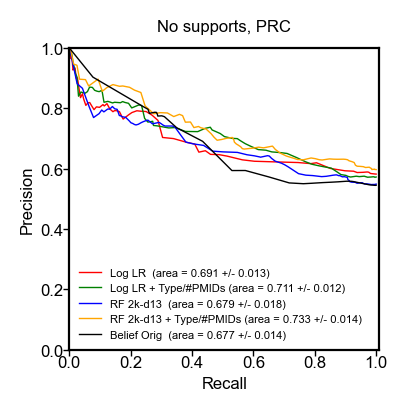

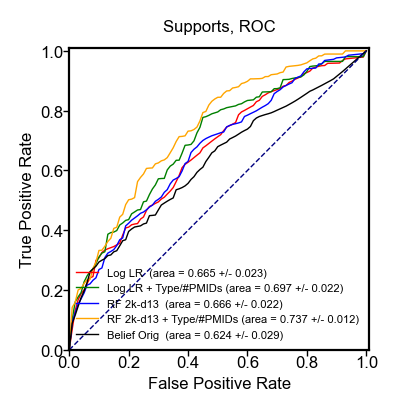

In [52]:
fig = plot_prc(no_supp_wt)
ax = fig.gca()
ax.set_title('No supports, PRC', fontsize=6)
ax.set_ylim(0, 1)
fig = plot_roc(supp_wt)
ax = fig.gca()
ax.set_title('Supports, ROC', fontsize=6)


<IPython.core.display.Javascript object>


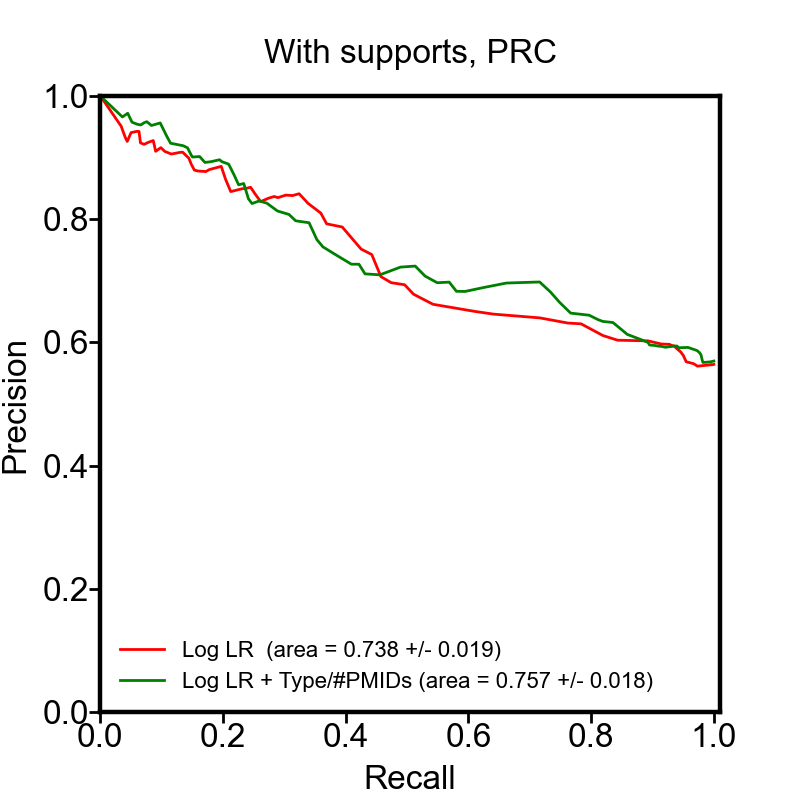

<IPython.core.display.Javascript object>


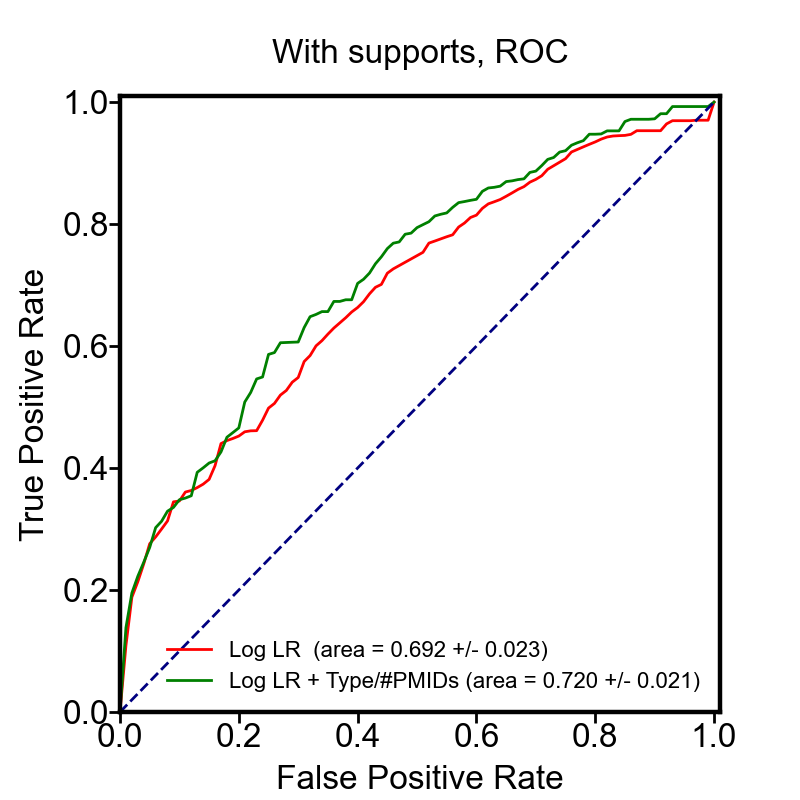

Text(0.5, 1.0, 'With supports, ROC')

In [85]:
fig = plot_prc(supp_both_fits)
ax = fig.gca()
ax.set_ylim(0, 1)

ax.set_title('With supports, PRC', fontsize=6)

fig = plot_roc(supp_both_fits)
ax = fig.gca()
ax.set_title('With supports, ROC', fontsize=6)


## Comparing combinations of readers

In [ ]:
reach_fits = eval_models_relation(models_ev, predictors, cur_df, ['reach'], None,
                              num_folds=10, cols_to_include=None, seed=1)
sparser_fits = eval_models_relation(models_ev, predictors, cur_df, ['sparser'], None,
                              num_folds=10, cols_to_include=None, seed=1)
reach_sparser_fits = eval_models_relation(models_ev, predictors, cur_df, ['reach', 'sparser'], None,
                              num_folds=10, cols_to_include=None, seed=1)

In [ ]:
#fig = plot_roc(reach_fits)
fig = plot_prc(reach_fits)
ax = fig.gca()
#ax.set_title('Reach, ROC', fontsize=6)
ax.set_title('Reach, PRC', fontsize=6)

In [ ]:
#fig = plot_roc(sparser_fits)
fig = plot_prc(sparser_fits)
ax = fig.gca()
#ax.set_title('Sparser, ROC', fontsize=6)
ax.set_title('Sparser, PRC', fontsize=6)

In [ ]:
#fig = plot_roc(reach_sparser_fits)
fig = plot_prc(reach_sparser_fits)
ax = fig.gca()
#ax.set_title('Reach or Sparser, ROC', fontsize=6)
ax.set_title('Reach or Sparser, PRC', fontsize=6)

In [ ]:
fig = plot_roc(res_ev)

In [ ]:
fig = plot_prc(res_ev)

We note that the performance of all classifiers increases with the number of readers used. We measured AUROC and AUPRC of each classifier starting with data from 1 reader and increasing to 5 and not surprisingly found that both increased with additional readers. It is important to note though that this analysis was performed using the unweighted curation dataset which is biased towards high-mention statements with a higher likelihood of reader overlap.

In [ ]:
def plot_aurocs(clf_aurocs, xticks, xticklabels, title, xlabel):
    fig = plt.figure(figsize=(2.5, 2), dpi=150)
    for clf_name, aurocs in clf_aurocs.items():
        plt.errorbar(xticks, aurocs['mean'], yerr=aurocs['se'], label=clf_name, marker='.',
                     lw=0.5)
    plt.legend(loc="lower right", frameon=False, fontsize=6)
    plt.ylabel('AUROC')
    #plt.title(title)
    plt.xticks(xticks)
    plt.xlabel(xlabel)
    ax = plt.gca()
    ax.set_xticklabels(xticklabels)
    plt.subplots_adjust(left=0.18, right=0.95)
    format_axis(ax)
    return fig

def plot_auprcs(clf_auprcs, xticks, xticklabels, title, xlabel):
    fig = plt.figure(figsize=(2.5, 2), dpi=150)
    for clf_name, auprcs in clf_auprcs.items():
        plt.errorbar(xticks, auprcs['mean'], yerr=auprcs['se'], label=clf_name, marker='.',
                     lw=0.5)
    plt.legend(loc="lower right", frameon=False, fontsize=6)
    plt.ylabel('AUPRC')
    #plt.title(title)
    plt.xticks(xticks)
    plt.xlabel(xlabel)
    plt.ylim([0.75, 1.0])
    ax = plt.gca()
    ax.set_xticklabels(xticklabels)
    plt.subplots_adjust(left=0.18, right=0.95)
    format_axis(ax)
    return fig

In [ ]:
def adding_readers(reader_list, df, num_folds=10):
    clf_aurocs = {}
    clf_auprcs = {}
    for i in range(1, len(reader_list) + 1):
        reader_subset = reader_list[0:i]
        #cols_to_drop = [col for col in df.columns if col not in reader_subset + ['correct']]
        #readers_to_drop = reader_list[i:]
        #train_df = df.drop(cols_to_drop, axis=1)
        #train_df = train_df[train_df[reader_subset].any(1)]
        #print(f"Readers: {reader_subset}; num_rows: {len(df)}; correct: {train_df.correct.mean()}")
        models_ev = {
            #'Logistic Regression': LogisticRegression(),
            'Log-Logistic Regression': LogLogisticRegression(),    
            #'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=6),
            #'Random Forest': RandomForestClassifier(),
            #'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
            #'Binary Random Forest': BinaryRandomForest(),
            #'Belief': BeliefModel(reader_subset),
            #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
            #                           nwalkers=100, burn_steps=100, sample_steps=100)
            #'GaussianNB': GaussianNB(),
        }
                
        res_ev = eval_models_relation(models_ev, df, reader_subset, None,
                                      num_folds=num_folds)
        for i, (clf_name, clf_res) in enumerate(res_ev.items()):
            clf_summary = clf_res.get_summary()
            roc_auc_arr = clf_summary['roc_auc']
            pr_auc_arr = clf_summary['pr_auc']
            if clf_name not in clf_aurocs:
                clf_aurocs[clf_name] = {'mean': [], 'se': []}                
            clf_aurocs[clf_name]['mean'].append(roc_auc_arr.mean())
            clf_aurocs[clf_name]['se'].append(roc_auc_arr.std() / np.sqrt(len(roc_auc_arr)))
            if clf_name not in clf_auprcs:
                clf_auprcs[clf_name] = {'mean': [], 'se': []}
            clf_auprcs[clf_name]['mean'].append(pr_auc_arr.mean())
            clf_auprcs[clf_name]['se'].append(pr_auc_arr.std())
    return (clf_aurocs, clf_auprcs)

Adding readers:

In [ ]:
#reader_list = list(reversed(['reach', 'medscan', 'sparser', 'trips', 'rlimsp'])) #'rlimsp'
reader_list = ['sparser', 'medscan', 'reach']

In [ ]:
#ar_aurocs, ar_auprcs = adding_readers(reader_list, kge_df, num_folds=10)
ar_aurocs, ar_auprcs = adding_readers(reader_list, cur_df, num_folds=10)

* Readers: ['reach']; num_rows: 1007; correct: 0.8083416087388282
* Readers: ['reach', 'medscan']; num_rows: 1176; correct: 0.7882653061224489
* Readers: ['reach', 'medscan', 'sparser']; num_rows: 1308; correct: 0.7408256880733946
* Readers: ['reach', 'medscan', 'sparser', 'trips']; num_rows: 1370; correct: 0.7372262773722628
* Readers: ['reach', 'medscan', 'sparser', 'trips', 'rlimsp']; num_rows: 1435; correct: 0.7344947735191638

In [ ]:
fig = plot_aurocs(ar_aurocs, list(range(len(reader_list))), reader_list,
            'Classifier AUROC with increasing readers', 'Reader added')
fig.savefig(fig_path('auroc_more_readers', 'pdf'))

In [ ]:
fig = plot_auprcs(ar_auprcs, list(range(len(reader_list))), reader_list,
           'Classifier AUPRC with increasing readers', 'Reader added')
fig.savefig(fig_path('auprc_more_readers', 'pdf'))

## Effect of adding data

In [ ]:
def adding_data(num_low_high, reader_list, df, num_folds=10):
    clf_aurocs = {}
    clf_auprcs = {}
    
    for i, (num_low, num_high) in enumerate(num_low_high):
        reader_subset = reader_list[0:i]
        readers_to_drop = reader_list[i:]
        train_df = df.drop(readers_to_drop, axis=1)
        
        def split_closure(x_data, y_data, test_size):
            return split_by_ev_ct(x_data, y_data, reader_list, low_ub=1, num_low=num_low,
                                  high_lb=8, num_high=num_high, test_size=test_size)
        
        models_ev = {
            'Logistic Regression': LogisticRegression(),
            'Log-Logistic Regression': LogLogisticRegression(),    
            #'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=4),
            #'Random Forest': RandomForestClassifier(),
            #'Binary Random Forest': BinaryRandomForest(n_estimators=1000, max_depth=4),
            #'Belief': BeliefModel(reader_subset),
            #'BeliefBayes': BeliefBayesModel(train_df, 0, reader_subset, model_class=None,
            #                           nwalkers=100, burn_steps=100, sample_steps=100)
            #'GaussianNB': GaussianNB(),
        }
        res_ev = eval_models_relation(models_ev, predictors, train_df, reader_list, split_closure,
                                      test_split=0.2, num_folds=num_folds)
        roc_auc = res_ev['roc_auc']
        pr_auc = res_ev['pr_auc']
        for i, (clf_name, roc_auc_arr) in enumerate(roc_auc.items()):
            pr_auc_arr = pr_auc[clf_name]
            if clf_name not in clf_aurocs:
                clf_aurocs[clf_name] = {'mean': [], 'sd': []}
            clf_aurocs[clf_name]['mean'].append(roc_auc_arr.mean())
            clf_aurocs[clf_name]['sd'].append(roc_auc_arr.std())
            if clf_name not in clf_auprcs:
                clf_auprcs[clf_name] = {'mean': [], 'sd': []}
            clf_auprcs[clf_name]['mean'].append(pr_auc_arr.mean())
            clf_auprcs[clf_name]['sd'].append(pr_auc_arr.std())
    return (clf_aurocs, clf_auprcs)

In [ ]:
num_low_high = [(5, 5), (10, 10), (20, 20), (30, 30)]
ad_aurocs, ad_auprcs = adding_data(num_low_high, reader_list, kge_df, num_folds=10)

In [ ]:
stmts_for_df

## Compare beliefs with preassembled evidences

In [100]:
y_arr = cur_df['correct'].values

In [101]:
all_sources = CountsScorer.get_all_sources(cur_stmts)
all_sources

['sparser',
 'signor',
 'bel',
 'isi',
 'biopax',
 'trrust',
 'rlimsp',
 'medscan',
 'reach',
 'trips',
 'hprd']

Fit to the whole curation dataset:

In [102]:
clf = LogLogisticRegression()
scorer = CountsScorer(clf, all_sources, use_stmt_type=True, use_num_pmids=True)
#scorer.fit(cur_stmts, y_arr)

In [106]:
for s in sorted(list(scorer.stmt_type_map)):
    print(s)

Acetylation
Activation
ActiveForm
AddModification
Association
Autophosphorylation
Complex
Conversion
Deacetylation
DecreaseAmount
Defarnesylation
Degeranylgeranylation
Deglycosylation
Dehydroxylation
Demethylation
Demyristoylation
Depalmitoylation
Dephosphorylation
Deribosylation
Desumoylation
Deubiquitination
Event
Farnesylation
Gap
Gef
Geranylgeranylation
Glycosylation
GtpActivation
HasActivity
Hydroxylation
IncreaseAmount
Influence
Inhibition
Methylation
Migration
Modification
Myristoylation
Palmitoylation
Phosphorylation
RegulateActivity
RegulateAmount
RemoveModification
Ribosylation
SelfModification
Sumoylation
Translocation
Transphosphorylation
Ubiquitination
Unresolved


In [ ]:
# Make a copy of the curation statements
all_stmts_copy = copy(all_stmts)

In [ ]:
be = BeliefEngine(scorer)
be.set_prior_probs(all_stmts_copy)

In [ ]:
prior_beliefs = {s.get_hash(): s.belief for s in all_stmts_copy}

In [ ]:
be.set_hierarchy_probs(all_stmts_copy)
hier_beliefs = {s.get_hash(): s.belief for s in all_stmts_copy}

In [ ]:
bel_diffs = []
for ix, stmt_hash in enumerate(prior_beliefs):
    stmt = stmts_by_hash[stmt_hash]
    prior_bel = prior_beliefs[stmt_hash]
    hier_bel = hier_beliefs[stmt_hash]
    diff = hier_bel - prior_bel
    none_subj = True if stmt.agent_list()[0] is None else False
    bel_diffs.append((ix, stmt, none_subj, prior_bel, hier_bel, diff))

In [ ]:
bel_diffs_df = pd.DataFrame.from_records(bel_diffs,
                         columns=['index', 'stmt', 'none_subj', 'prior',
                                  'hier', 'diff'],
                         index='index')

In [ ]:
bel_diffs_df.to_pickle('/Users/johnbachman/Desktop/belief_diffs.pkl')

In [ ]:
bel_diffs_subj = bel_diffs_df[~bel_diffs_df['none_subj']]
bel_diffs_subj.sort_values(by='diff', ascending=True)[200:250]

In [ ]:
stmt = bel_diffs_subj.loc[224600]['stmt']
pps([stmt])

In [ ]:
stmt.supports

In [ ]:
pps(stmt.supports)

# Include RGCN Scores

In [ ]:
rgcn_df = pd.read_csv('curated_with_scores.csv', index_col=0)

In [ ]:
rgcn_df.score

In [ ]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)